<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/Entregable_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas 
import missingno as msn
from scipy import stats

import seaborn
seaborn.set_context('talk')
pandas.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'4.4.1'

In [3]:
# To update plotly, uncomment and run the following line:
# !pip install plotly --upgrade

In [4]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,nan,nan,Yarra,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
2,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00


## Ejercicio 1: 

1. Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

1. Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.
  1. Justificar cada columna no seleccionada.
  2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.


In [5]:
# data source:
# https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
airbnb_df[:3]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.77,145.09,60,nan,nan
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.77,144.98,35,200.00,803.00
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.86,144.98,159,1253.00,4452.00


## Ejercicio 2: Imputación

1. Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).

2. Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.



## Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

#### Funcion

In [7]:
def boxanalisis(serie):
  q1=serie.quantile([.25])
  print('Q1: ',q1.values )
  q3=serie.quantile([.75])
  print('Q3: ',q3.values )
  iqr= q3.values - q1.values
  print('IQR: ',iqr)

  bigote_inf= q1.values - (iqr * 1.5)
  print('Limite Inferior Teorico: ',bigote_inf)

  min = serie.min()
  print('Valor MIN: ',min)

  #Comparamos el limite inferior teórico respecto del valor minimo observado, para saber cual valor tomar.
  if (bigote_inf < min):
    lim_min= min
  else:
    lim_min=bigote_inf

  bigote_sup= q3.values + (iqr * 1.5)
  print('Limite Superior Teorico: ',bigote_sup)

  max=  serie.max()
  print('Valor MAX: ',max)

  #Comparamos el limite superior teórico respecto del valor maximo observado, para saber cual valor tomar.
  if (bigote_sup > max):
    lim_max= max
  else:
    lim_max=bigote_sup
      
  print('El limite SUPERIOR (bigote derecho) de los datos sin considerar valores atípicos es: ',lim_max)
  print('El limite INFERIOR (bigote izquierdo) de los datos sin considerar valores atípicos es: ',lim_min)




In [8]:
def valores_eliminados(serie,out=(0.01,0.99)): 
      resultado=None
      limite_sup=serie.quantile(out[1])
      print(f'Limite superior propuesto (Percentil {out[1]}): {limite_sup.round(2)} \nValores que quedarian fuera: {(serie>limite_sup).sum()}\n')

      limite_inf=serie.quantile(out[0])
      print(f'Limite inferior propuesto (Percentil {out[0]}): {limite_inf.round(2)}  \nValores que quedarian fuera: {(serie<limite_inf).sum()}\n')
      result=(limite_inf,limite_sup) 

      return (result)      

In [9]:
##FUNCION para el estudio de las variables

def estudio(serie,out=(0.01,0.99),n=8,bin=50,size=(18,7),variable='ninguna',min=None): 

  #Serie a estudiar, definición de limites outliers, cantidad de categorias para variables categoricas y discretas, 
  #cantidad de bins para continuas y tamaño de la figura
  resultado=None
  print('Cantidad de NaN:',serie.isna().sum()) #Cantidad de valores Nan en la Serie
  
  #Determinación del tipo de variable
  if variable=='ninguna':
    if serie.dtype.name in ('object','category'):
      serie=serie.astype('category')
      variable='categoria'
    elif serie.dtype.name in ('float','float64','float32','float16'):
      variable='continua'
    elif serie.dtype.name in ('int','int32','int64','int16','Int8','Int16','Int32','int8'):
      variable='discreta'

  print('Tipo de variable: ',variable)


  #CATEGORICAS

  if variable=='categoria':
    countplt, ax = plt.subplots(figsize = size)
    categorias=serie.unique()
    print('Cantidad de valores unicos:',len(categorias))
    resumen=serie.value_counts()
    if min!=None:
      filtro=resumen>min
      n=filtro.sum()
    if len(categorias)<=n:
      nva=resumen.nlargest(n)
      orden=list(nva.index)
      ax=seaborn.countplot(x=serie,order=orden)
    else:
      dict={}
      nva=resumen.nlargest(n-1)
      orden=list(nva.index)
      for i in resumen.index:
        if resumen.loc[i]<nva.iloc[-1]:
          dict[i]='Otro'
        else:
          dict[i]=i
      orden=orden+['Otro']
      serie2=serie.replace(dict)
      resultado=(serie2)
      ax=seaborn.countplot(x=serie2,order=orden)
    for rect in ax.patches:
      ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
    plt.xticks(rotation=30);
    

  #Continuas

  elif variable=='continua':
    if out != 0:
      limite_sup=serie.quantile(out[1])
      print(f'Limite superior propuesto (cuantil {out[1]}): {limite_sup.round(2)} \nValores que quedarian fuera: {(serie>limite_sup).sum()}\n')

      limite_inf=serie.quantile(out[0])
      print(f'Limite inferior propuesto (cuantil {out[0]}): {limite_inf.round(2)}  \nValores que quedarian fuera: {(serie<limite_inf).sum()}\n')
      resultado=(limite_inf,limite_sup,serie) 
    fig, ax = plt.subplots(2,1,figsize = size)
    seaborn.histplot(serie,bins=bin,ax=ax[0])
    seaborn.boxplot(serie,ax=ax[1])
    print(serie.describe())
 
  #Discretas

  elif variable=='discreta':
    
    if out != 0:
      limite_sup=serie.quantile(out[1])
      print(f'Limite superior propuesto (cuantil {out[1]}): {limite_sup}  \nValores que quedarian fuera: {(serie>limite_sup).sum()}\n')
      limite_inf=serie.quantile(out[0])
      print(f'Limite inferior propuesto (cuantil {out[0]}): {limite_inf} \nValores que quedarian fuera: {(serie<limite_inf).sum()}\n')
      resultado=(limite_inf,limite_sup,serie)
    categorias=serie.unique()
    if len(categorias)>2*bin:
      fig, ax = plt.subplots(2,1,figsize = size)
      seaborn.histplot(serie,bins=bin,ax=ax[0])
      seaborn.boxplot(serie,ax=ax[1])
      print(serie.describe())
    else:
      resumen=serie.value_counts()
      countplt, ax = plt.subplots(figsize = size)
      categorias=serie.unique()
      if len(categorias)<=n:
        nva=resumen.nlargest(n)
        orden=list(nva.index).sort()
        ax=seaborn.countplot(x=serie,order=orden)
        print(serie.describe())#mimi
      else:
        dict={}
        nva=resumen.nlargest(n-1)
        for i in resumen.index:
          if resumen.loc[i]<nva.iloc[-1]:
            dict[i]='Otro'
          else:
            dict[i]=i
        serie2=serie.replace(dict)
        orden=list(nva.index)
        orden.sort()
        orden=orden+['Otro']
        ax=seaborn.countplot(x=serie2,order=orden)
        print(serie.describe())
      for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)
      plt.xticks(rotation=30);
  return (resultado)



#**Respuestas**

##**EJERCICIO Nº 1**

####***Columnas y Significados***



**Suburb**: Suburbio

**Address**: Dirección

**Rooms**: Número de habitaciones

**Price**: Precio en dólares australianos

**Method**:
S - propiedad vendida;
SP - propiedad vendida antes;
PI - propiedad transferida;
PN - vendido antes no revelado;
SN - vendido no revelado;
NB - sin oferta;
VB - oferta del proveedor;
W - retirado antes de la subasta;
SA - vendido después de subasta;
SS - vendido después del precio de subasta no revelado.
N / A - precio o oferta más alta no disponible.

**Type**:
br - dormitorio (s);
h - casa, cabaña, villa, semi, terraza;
u - unidad, dúplex;
t - casa adosada;
dev site - sitio de desarrollo;
o res - otro residencial.

**SellerG**: Agente de bienes raíces

**Date**: fecha de venta

**Distance**: Distancia del CBD (Melbourne Central Business district) en kilómetros.

**Regionname**: Región general (Oeste, Noroeste, Norte, Noreste… etc.)

**Propertycount**: Número de propiedades que existen en el suburbio.

**Bedroom2**: Scraped número de dormitorios (de una fuente diferente)

**Bathroom**: Cantidad de baños

**Car**: Número de plazas

**Landsize**: Tamaño del terreno en metros

**BuildingArea**: Tamaño del edificio en metros

**YearBuilt**: año en que se construyó la casa

**CouncilArea**: Consejo de Gobierno del área

**Lattitude**: coordenada

**Longtitude**: coordenada

Eliminaremos los valores extremos que no sean relevantes para la predicción de valores de las propiedades.


Obtenemos la cantidad de registros a procesar en el dataframe original.


In [10]:
print('Número de filas dataframe original:',len(melb_df.index))


Número de filas dataframe original: 13580


Obtenemos la información de las columnas: tipos de datos y cantidad de valores nulos.

In [11]:
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

Clasificamos las columnas por tipos.

In [12]:
categoricas=['Suburb','Address','Type','Method','SellerG','Postcode','CouncilArea','Regionname']
discretas=['Rooms','Car','Bedroom2','Bathroom','Propertycount','YearBuilt']
continuas=['Price','Distance','Lattitude','Longtitude','BuildingArea', 'Landsize']
tiempo=['Date']


obtenemos la cantidad de nulos en cada columna.

In [13]:
melb_df.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [14]:
#Cambiar tipo de dato para trabajarlos mejor
melb_df['date'] = pandas.to_datetime(melb_df.Date)
melb_df['Postcode'] = melb_df['Postcode'].astype(int) #primero pasamos del float a entero, antes de pasarlo a categorica
tipos={'Suburb':'category','Address':'category','Rooms':'int8', 'Type':'category',
       'Method':'category','SellerG':'category','Postcode':'category','Bedroom2':'int8',
       'Bathroom':'int8','Car':'Int8','YearBuilt':'Int16','CouncilArea':'category','Regionname':'category',
       'Propertycount':'int16'
       }

melb_df=melb_df.astype(tipos)
melb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         13580 non-null  category      
 1   Address        13580 non-null  category      
 2   Rooms          13580 non-null  int8          
 3   Type           13580 non-null  category      
 4   Price          13580 non-null  float64       
 5   Method         13580 non-null  category      
 6   SellerG        13580 non-null  category      
 7   Date           13580 non-null  object        
 8   Distance       13580 non-null  float64       
 9   Postcode       13580 non-null  category      
 10  Bedroom2       13580 non-null  int8          
 11  Bathroom       13580 non-null  int8          
 12  Car            13518 non-null  Int8          
 13  Landsize       13580 non-null  float64       
 14  BuildingArea   7130 non-null   float64       
 15  YearBuilt      8205

####**Shapiro-Wilk Test**

Vamos a realizar un test de normalidad a la variables numéricas para detectar aquellas que siguen esta distribución.


El test de Shapiro-Wilks plantea la hipótesis nula que una muestra proviene de una distribución normal. Eligimos un nivel de significanza, por ejemplo 0,05, y tenemos una hipótesis alternativa que sostiene que la distribución no es normal.

H0 : La distribución es normal

H1 : La distribución no es normal,

VARIABLES CONTINUAS

In [15]:
alpha = 0.05
for i in continuas:
    print ([i])
    muestra_df=melb_df[[i]].dropna().sample(4500)
    a,b= stats.shapiro(muestra_df)

    print ("Statistics", a, "p-value", b)
    if b < alpha:  
        print("Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal")
    else:
        print("NO rechazamos la hipótesis nula. Los datos de la muestra SI provienen de una distribución normal.")

['Price']
Statistics 0.8306716680526733 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Distance']
Statistics 0.8937852382659912 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Lattitude']
Statistics 0.9824175834655762 p-value 3.1499547267055194e-23
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Longtitude']
Statistics 0.9842809438705444 p-value 5.582904184107054e-22
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['BuildingArea']
Statistics 0.03205078840255737 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Landsize']
Statistics 0.12872201204299927 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal


VARIABLES DISCRETAS

In [16]:
alpha = 0.05
for j in discretas:
    print ([j])
    muestra_df= melb_df[[j]].dropna().sample(4500)
    a,b= stats.shapiro(muestra_df)

    print ("Statistics", a, "p-value", b)
    if b < alpha:  
        print("Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal")
    else:
        print("NO rechazamos la hipótesis nula. Los datos de la muestra SI provienen de una distribución normal.")

['Rooms']
Statistics 0.8982089757919312 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Car']
Statistics 0.8194214701652527 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Bedroom2']
Statistics 0.89622563123703 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Bathroom']
Statistics 0.722754955291748 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['Propertycount']
Statistics 0.9246050715446472 p-value 8.127531093083939e-43
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal
['YearBuilt']
Statistics 0.8877218961715698 p-value 0.0
Rechazamos la hipótesis nula. Los datos de la muestra NO provienen de una distribución normal


####**1. Análisis Datos Erróneos - Datos Atípicos**

Un dato atípico es aquella observación que está muy distante del resto de los datos.
Vamos a identificar valores atípicos en las variables usando diagramas de caja y la regla de proximidad de rango intercuantil.
  
La caja de un boxplot comienza en el primer cuartil Q1 (25%) y termina en el tercero Q3 (75%). 
Por lo tanto, la caja representa el 50% de los datos centrales, con una línea dentro que representa la mediana. El ancho de la caja representa el IQR que es el rango intercuantil IQR (Q3-Q1).
A cada lado de la caja se dibuja un segmento con los datos más lejanos sin contar los valores atípicos (outliers), que en caso de existir, se representarán con círculos.
Estos segmentos se denominan bigotes y determinan el límite para la detección de valores atípicos.

De acuerdo con la regla de proximidad del rango entre cuantiles, un valor es un valor atípico si cae fuera de los límites siguientes:

> Limite Superior = Q3 + (IQR * 1.5)

> Limite Inferior = Q1 - (IQR * 1.5)

En el caso del límite superior, si el máximo no supera ese valor, la longitud del bigote será desde el tercer cuartil hasta el máximo.

En el caso del límite inferior, si el mínimo no supera ese valor, la longitud del bigote será desde el primer cuartil hasta el mínimo.


##### Analisis de **Price**

Creamos un dataframe auxiliar con los datos de la columna Price y obtenemos sus medidas descriptivas de tendencia central.

In [17]:
precio_df=melb_df['Price']
print('Media', precio_df.mean())
print('Mediana',precio_df.median())
print('Desviación Estándar',precio_df.std())

Media 1075684.079455081
Mediana 903000.0
Desviación Estándar 639310.7242960194


Graficamos la distribución de frecuencias de las variables mediante un histograma y analizaremos su dispersión con un boxplot.

Cantidad de NaN: 0
Tipo de variable:  continua
count     13580.00
mean    1075684.08
std      639310.72
min       85000.00
25%      650000.00
50%      903000.00
75%     1330000.00
max     9000000.00
Name: Price, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000., 1800000., 2000000., 2200000.,
        2400000., 2600000., 2800000., 3000000., 3200000., 3400000.,
        3600000., 3800000., 4000000., 4200000., 4400000., 4600000.,
        4800000., 5000000., 5200000., 5400000., 5600000., 5800000.,
        6000000., 6200000., 6400000., 6600000., 6800000., 7000000.,
        7200000., 7400000., 7600000., 7800000., 8000000., 8200000.,
        8400000., 8600000., 8800000., 9000000., 9200000.]),
 <a list of 47 Text major ticklabel objects>)

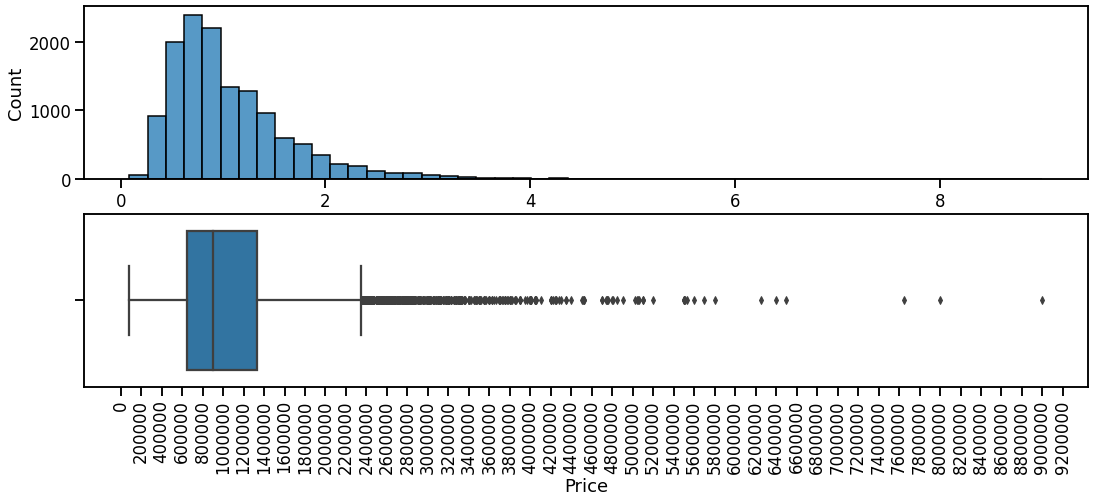

In [18]:
limites=estudio(precio_df, out=0)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(0,melb_df['Price'].max()+250000,step=200000))
plt.xticks(rotation=90)

Analizamos el boxplot.

In [19]:
boxanalisis(precio_df)

Q1:  [650000.]
Q3:  [1330000.]
IQR:  [680000.]
Limite Inferior Teorico:  [-370000.]
Valor MIN:  85000.0
Limite Superior Teorico:  [2350000.]
Valor MAX:  9000000.0
El limite SUPERIOR (bigote derecho) de los datos sin considerar valores atípicos es:  [2350000.]
El limite INFERIOR (bigote izquierdo) de los datos sin considerar valores atípicos es:  85000.0


**De la gráfica observada y los valores obtenidos, podemos determinar que no existen valores atípicos en el extremo inferior. Si existen valores atípicos más allá del límite superior establecido en 2.350.000 AUD.**

Obtenemos el valor de algunos otros percentiles con el objeto de seleccionar aquel cuyo valor sea más cercano al límite establecido.

In [20]:
precio_df.quantile([.90, .91, .92, .93, .94, .95, .955, .96, .97, .98, .99])

0.90   1850000.00
0.91   1900000.00
0.92   1969520.00
0.93   2050000.00
0.94   2170000.00
0.95   2290050.00
0.95   2352362.50
0.96   2410000.00
0.97   2600000.00
0.98   2865360.00
0.99   3338150.00
Name: Price, dtype: float64

Se observa que el limite de 1,5 veces el rango intercuartilico se aproxima a un percentil de 95,5% y nos parece un buen limite para limpiar los outliers superiores

In [21]:
#definimos aqui el percentil seleccionado
percentil_inferior=0
percentil_superior=0.955


Utilizamos nuestra funcion valores_eliminados para determinar cuantos valores dejariamos fuera con dichos percentiles.


In [22]:
limites=valores_eliminados(precio_df, out=(percentil_inferior,percentil_superior))


Limite superior propuesto (Percentil 0.955): 2352362.5 
Valores que quedarian fuera: 612

Limite inferior propuesto (Percentil 0): 85000.0  
Valores que quedarian fuera: 0



**Finalmente, establecemos solo un valor limite superior en 2.352.362,5 AUD. 
Dado que Price es la columna en la cual basamos nuestro análisis y queremos poder precedir, creemos correcto en este caso hacer un tratamiento de los valores atípicos mediante la  "eliminacion completa de la fila".**

Procedemos a filtrar el datafame utilizando el limite superior calculado.

In [23]:
melb_df= melb_df[(melb_df['Price']<=limites[1])]

print('Número de filas POST 1º filtro:',len(melb_df.index))

Número de filas POST 1º filtro: 12968


Graficamos nuevamente la distribución de la variable luego de aplicar el filtrado.

Cantidad de NaN: 0
Tipo de variable:  continua
count     12968.00
mean     982625.76
std      454624.27
min       85000.00
25%      637375.00
50%      880000.00
75%     1270000.00
max     2350000.00
Name: Price, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([  85000.,  185000.,  285000.,  385000.,  485000.,  585000.,
         685000.,  785000.,  885000.,  985000., 1085000., 1185000.,
        1285000., 1385000., 1485000., 1585000., 1685000., 1785000.,
        1885000., 1985000., 2085000., 2185000., 2285000., 2385000.]),
 <a list of 24 Text major ticklabel objects>)

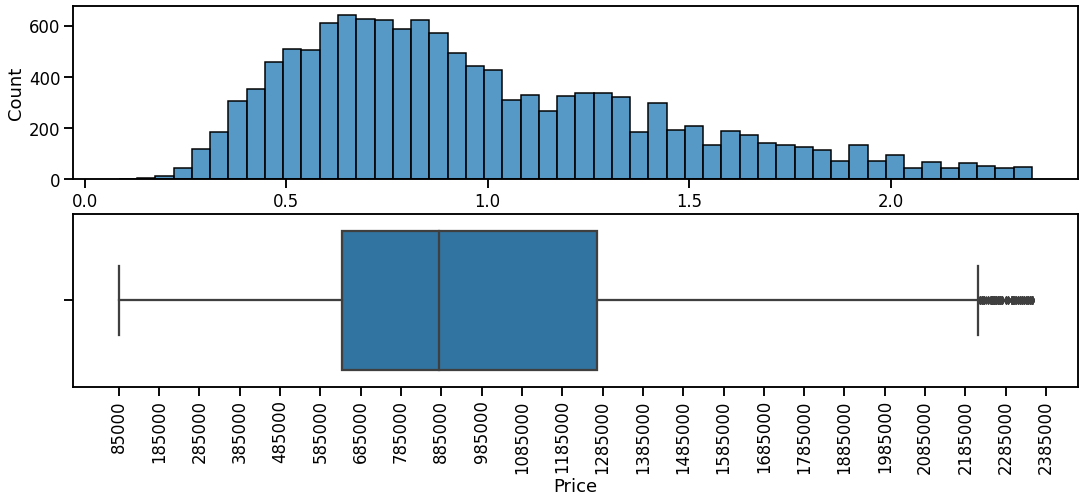

In [24]:
estudio(melb_df.Price,out=0)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(limites[0],limites[1]+100000,step=100000))
plt.xticks(rotation=90)

##### Analisis de **YearBuilt**

Graficamos la distribución de frecuencias de las variables mediante un histograma y analizaremos su dispersión con un boxplot.

Cantidad de NaN: 5162
Tipo de variable:  discreta
count   7806.00
mean    1965.72
std       36.58
min     1196.00
25%     1950.00
50%     1970.00
75%     1999.00
max     2018.00
Name: YearBuilt, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([1196, 1246, 1296, 1346, 1396, 1446, 1496, 1546, 1596, 1646, 1696,
        1746, 1796, 1846, 1896, 1946, 1996, 2046, 2096]),
 <a list of 19 Text major ticklabel objects>)

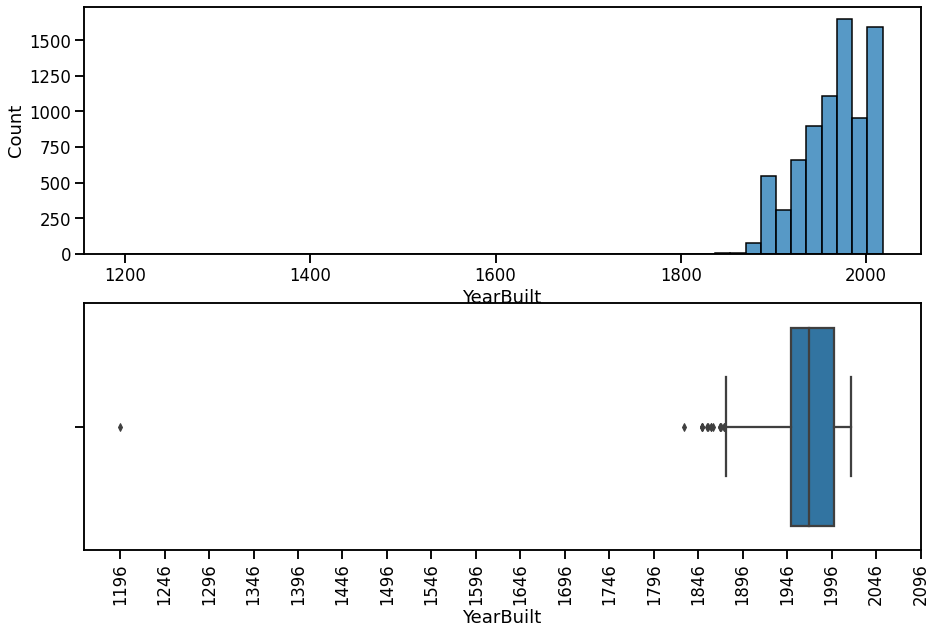

In [25]:
estudio(melb_df['YearBuilt'],out=0,n=11,size=(15,10))
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(melb_df['YearBuilt'].min(),melb_df['YearBuilt'].max()+100,step=50))
plt.xticks(rotation=90)

**Respecto a la existencia de muchos valores NaN, decidimos en este punto no hacer un tratamiento de los mismos, ya que se realizará en el siguiente bajo el análisis de valores faltantes.**

Analizamos el boxplot.

In [26]:
boxanalisis(melb_df['YearBuilt'])

Q1:  [1950.0]
Q3:  [1999.0]
IQR:  [49.0]
Limite Inferior Teorico:  [1876.5]
Valor MIN:  1196
Limite Superior Teorico:  [2072.5]
Valor MAX:  2018
El limite SUPERIOR (bigote derecho) de los datos sin considerar valores atípicos es:  2018
El limite INFERIOR (bigote izquierdo) de los datos sin considerar valores atípicos es:  [1876.5]


**De la gráfica observada y los valores obtenidos, podemos determinar que no existen valores atípicos en el extremo superior. Si existen valores atípicos más allá del límite inferior establecido, por ejemplo una propiedad del año 1196, pero no sabemos si es un error o un valor real.
Procederemos a aplicar un filtro con el lmite inferior calculado.**

In [27]:
#creamos un nuevo data frame sobre el que vamos a aplicar los filtros, para no generar sesgos e aplicar filtro y analizar la variable a filtrada

melb_df_filtrado=melb_df[(melb_df['YearBuilt'] > 1876)|(melb_df['YearBuilt'].isnull())]

print('Número de filas POST 2º filtro:',len(melb_df_filtrado.index))

Número de filas POST 2º filtro: 12952


Cantidad de NaN: 5162
Tipo de variable:  discreta
count   7790.00
mean    1966.03
std       35.25
min     1877.00
25%     1950.00
50%     1970.00
75%     2000.00
max     2018.00
Name: YearBuilt, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



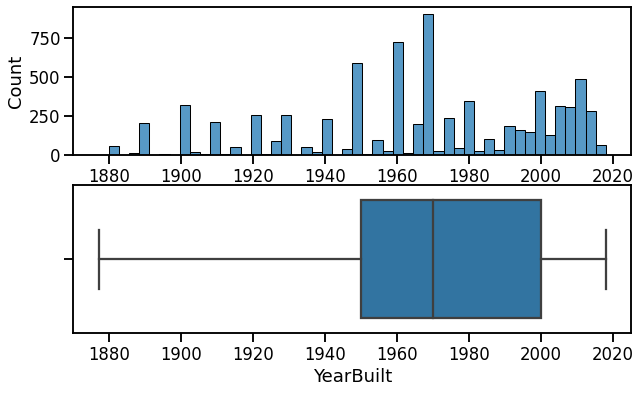

In [28]:
estudio(melb_df_filtrado['YearBuilt'],out=0,size=(10,6))

##### Analisis de **Landsize**

Graficamos la distribución de frecuencias de las variables mediante un histograma y analizaremos su dispersión con un boxplot.

Cantidad de NaN: 0
Tipo de variable:  continua
count   12968.00
mean      517.31
std      1497.58
min         0.00
25%       168.00
50%       416.00
75%       645.00
max     76000.00
Name: Landsize, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]), <a list of 9 Text major ticklabel objects>)

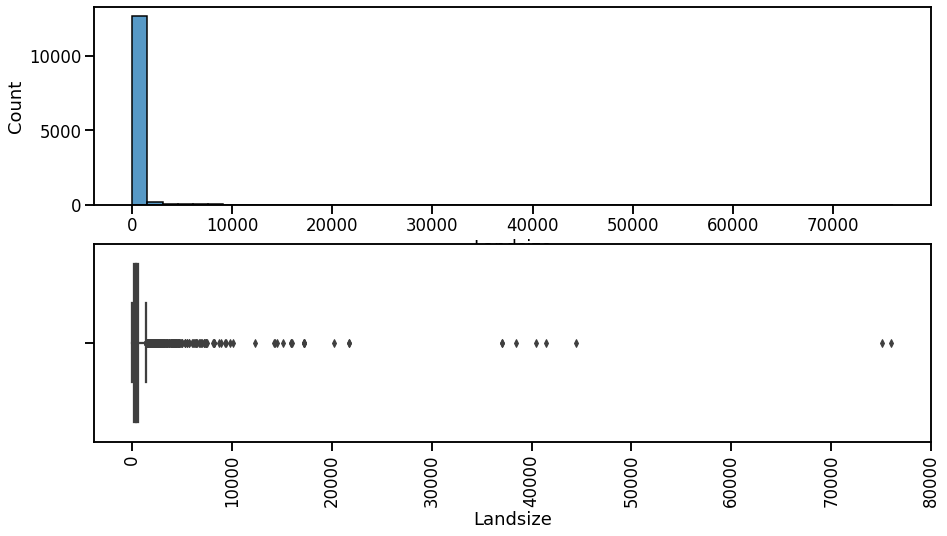

In [29]:
estudio(melb_df['Landsize'],out=0,size=(15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(melb_df['Landsize'].min(),melb_df['Landsize'].max()+10000,step=10000))
plt.xticks(rotation=90)

Del histograma, podemos visualizar que hay muchas observaciones que poseen el valor cero en la variable Landsize (es la moda), pero esta variable representa el tamaño del terreno en metros, por lo que estos valores podrían ser producto de un error de codificación o debido a la existencia de departamentos o construccione spor el estilo

In [30]:
moda= melb_df.Landsize.mode()
print('MODA: ', moda.to_string(index=False))

cantidad_ceros= len(melb_df[(melb_df['Landsize'] == 0)].index)
print('Cantidad de Ceros: ',cantidad_ceros)

MODA:  0.00
Cantidad de Ceros:  1926


**En este punto no vamos a hacer un tratamiento de los mismos, ya que se realizará en el siguiente bajo el análisis de valores faltantes.**

**Por otro lado, en el gráfico de boxplot observamos que existen valores atípicos inmensamente más grandes que la media.**
Procedemos a calcular los valores del boxplot, ya que la escala no nos permite visualizarlos con claridad.


In [31]:
boxanalisis(melb_df['Landsize'])

Q1:  [168.]
Q3:  [645.]
IQR:  [477.]
Limite Inferior Teorico:  [-547.5]
Valor MIN:  0.0
Limite Superior Teorico:  [1360.5]
Valor MAX:  76000.0
El limite SUPERIOR (bigote derecho) de los datos sin considerar valores atípicos es:  [1360.5]
El limite INFERIOR (bigote izquierdo) de los datos sin considerar valores atípicos es:  0.0


**De la gráfica observada y los valores obtenidos, podemos determinar que no existen valores atípicos en el extremo inferior. Si existen valores atípicos más allá del límite superior establecido en 1360.5, por ejemplo una propiedad con un valor de mas de 76000 metros cuadrados, pero no sabemos si es un error o un valor real. 
Procederemos a aplicar un filtro con el limite superior calculado.**

In [32]:
melb_df_filtrado=melb_df_filtrado[(melb_df_filtrado['Landsize'] < 1360.5)]

print('Número de filas POST 3º filtro:',len(melb_df_filtrado.index))

Número de filas POST 3º filtro: 12612


Cantidad de NaN: 0
Tipo de variable:  continua
count   12612.00
mean      403.41
std       283.80
min         0.00
25%       163.00
50%       400.00
75%       627.00
max      1357.00
Name: Landsize, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300.]),
 <a list of 14 Text major ticklabel objects>)

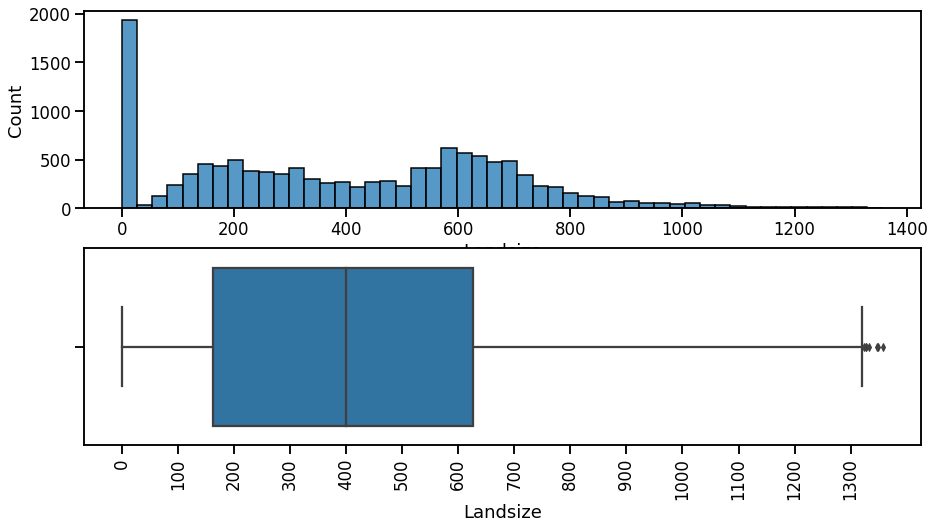

In [33]:
estudio(melb_df_filtrado['Landsize'],out=0,size=(15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(melb_df_filtrado['Landsize'].min(),melb_df_filtrado['Landsize'].max(),step=100))
plt.xticks(rotation=90)

##### Analisis de **BuildingArea**

Graficamos la distribución de frecuencias de las variables mediante un histograma y analizaremos su dispersión con un boxplot.

Cantidad de NaN: 6195
Tipo de variable:  continua
count    6773.00
mean      145.09
std       552.59
min         0.00
25%        91.00
50%       122.00
75%       165.00
max     44515.00
Name: BuildingArea, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
         8000.,  9000., 10000., 11000., 12000., 13000., 14000., 15000.,
        16000., 17000., 18000., 19000., 20000., 21000., 22000., 23000.,
        24000., 25000., 26000., 27000., 28000., 29000., 30000., 31000.,
        32000., 33000., 34000., 35000., 36000., 37000., 38000., 39000.,
        40000., 41000., 42000., 43000., 44000., 45000.]),
 <a list of 46 Text major ticklabel objects>)

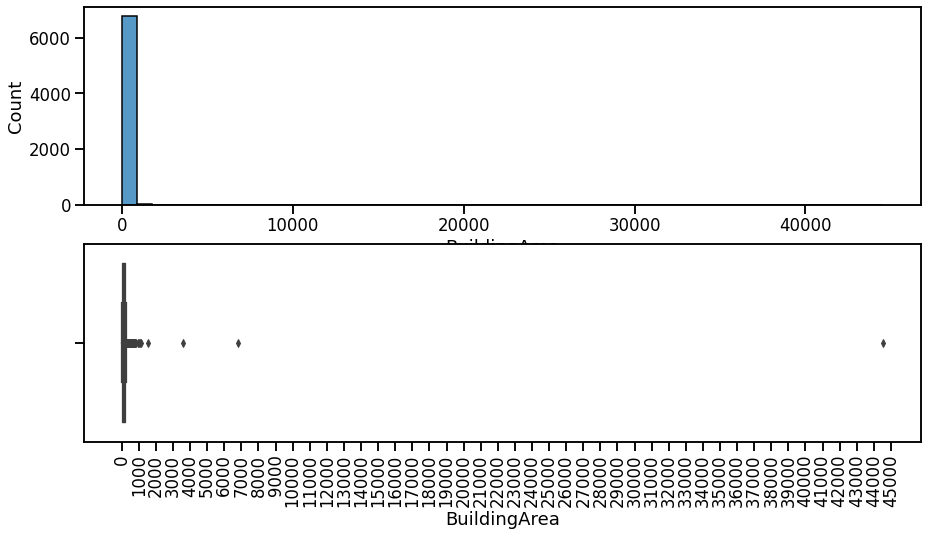

In [34]:
estudio(melb_df['BuildingArea'],out=0,size=(15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(melb_df['BuildingArea'].min(),melb_df['BuildingArea'].max()+1000,step=1000))
plt.xticks(rotation=90)

Del histograma, podemos visualizar que hay varias observaciones que poseen el valor cero en la variable BuildingArea, pero **esta variable representa el tamaño del edificio en metros y no puede ser 0**, por lo que estos valores podrían ser producto de un error de codificación.

In [35]:
cantidad_ceros= len(melb_df[(melb_df['BuildingArea'] == 0)].index)
print('Cantidad de Ceros: ',cantidad_ceros)

Cantidad de Ceros:  13


Tambien existen muchos valores NaN, pero como indicamos anteriormente, esta variable no puede ser nula ya que representa la cantidad de metros construidos.

**En este punto no vamos a hacer un tratamiento de los valores Nan ni de los valores 0, ya que se realizará en el siguiente punto bajo el análisis de valores faltantes.**

Por otro lado, en el gráfico de boxplot observamos que existen valores atípicos más grandes que la media. Procedemos a calcular los valores del boxplot, ya que la escala no nos permite visualizarlos con claridad.

In [36]:
boxanalisis(melb_df['BuildingArea'])

Q1:  [91.]
Q3:  [165.]
IQR:  [74.]
Limite Inferior Teorico:  [-20.]
Valor MIN:  0.0
Limite Superior Teorico:  [276.]
Valor MAX:  44515.0
El limite SUPERIOR (bigote derecho) de los datos sin considerar valores atípicos es:  [276.]
El limite INFERIOR (bigote izquierdo) de los datos sin considerar valores atípicos es:  0.0


**De la gráfica observada y los valores obtenidos, podemos determinar que no existen valores atípicos en el extremo inferior. Si existen valores atípicos más allá del límite superior establecido en 276, por ejemplo una propiedad con un valor de mas de 44000 metros cuadrados, pero no sabemos si es un error o un valor real. 
Procederemos a aplicar un filtro con el limite superior calculado.**

In [37]:
melb_df_filtrado=melb_df_filtrado[(melb_df_filtrado['BuildingArea'] <= 276)|(melb_df_filtrado['BuildingArea'].isnull())]

print('Número de filas POST 4º filtro:',len(melb_df.index))

Número de filas POST 4º filtro: 12968


Cantidad de NaN: 6010
Tipo de variable:  continua


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



count   6332.00
mean     127.26
std       52.63
min        0.00
25%       91.00
50%      120.00
75%      159.00
max      276.00
Name: BuildingArea, dtype: float64



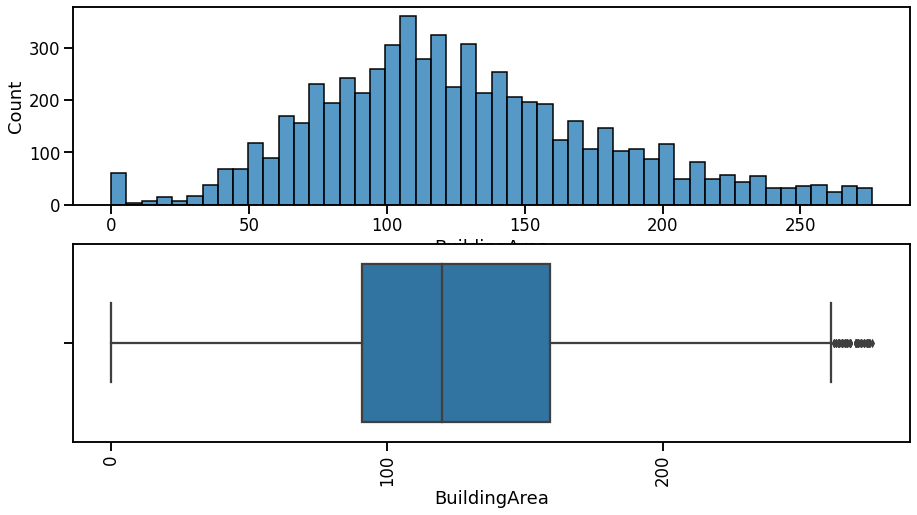

In [38]:
estudio(melb_df_filtrado['BuildingArea'],out=0,n=11,size=(15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(melb_df_filtrado['BuildingArea'].min(),melb_df_filtrado['BuildingArea'].max(),step=100))
plt.xticks(rotation=90)
print()

##### Analisis de **Rooms** y **Bedroom2**

Graficamos la distribución de frecuencias de las variables mediante un gráfico de barras.

Cantidad de NaN: 0
Tipo de variable:  discreta
count   12968.00
mean        2.89
std         0.93
min         1.00
25%         2.00
50%         3.00
75%         3.00
max        10.00
Name: Rooms, dtype: float64


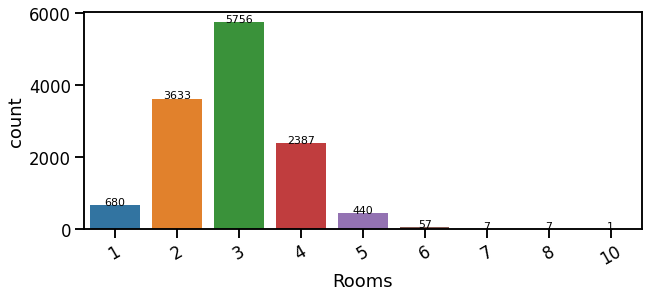

In [39]:
estudio(melb_df['Rooms'],out=0,n=9,size=(10,4))

Cantidad de NaN: 0
Tipo de variable:  discreta
count   12968.00
mean        2.86
std         0.94
min         0.00
25%         2.00
50%         3.00
75%         3.00
max        20.00
Name: Bedroom2, dtype: float64


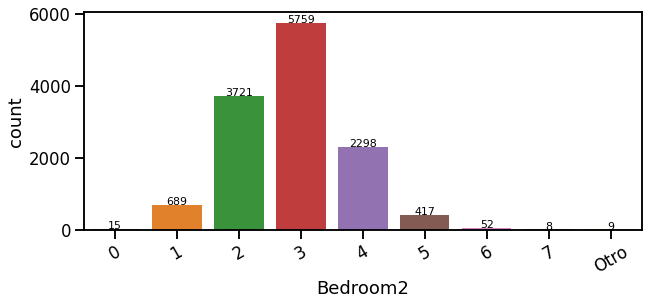

In [40]:
estudio(melb_df['Bedroom2'],out=0,n=9,size=(10,4))

Generando una crosstab de las dos variables podemos observar lo siguiente:

* Existen inconsistencias entre las cantidades informadas para una misma observación por ambas columnas. Por ejemplo: las propiedades que poseen una habitación en la columna Rooms son 681. Solo 663 de dichas propiedades informan en la columna Bedroom2 el valor uno, el resto informan dos (16) y tres (2)habitaciones.

* La columna **Bedroom2** presenta valores atípicos como cero, nueve y veinte habitaciones, no existentes en la columna Rooms.

Consideramos entonces que estos valores atípicos de la columna Bedroom2 podrían ser **valores mal codificados.**

In [41]:
pandas.crosstab(melb_df.Rooms, melb_df.Bedroom2,margins = True) 

Bedroom2,0,1,2,3,4,5,6,7,8,9,10,20,All
Rooms,,,,,,,,,,,,,
1,0,662,16,2,0,0,0,0,0,0,0,0,680
2,5,20,3526,73,8,1,0,0,0,0,0,0,3633
3,8,5,160,5510,66,5,0,0,0,1,0,1,5756
4,2,2,18,160,2192,12,0,0,0,1,0,0,2387
5,0,0,1,13,27,397,0,1,1,0,0,0,440
6,0,0,0,1,4,1,50,1,0,0,0,0,57
7,0,0,0,0,0,1,0,6,0,0,0,0,7
8,0,0,0,0,1,0,2,0,4,0,0,0,7
10,0,0,0,0,0,0,0,0,0,0,1,0,1


La variable Bedroom2 es obtenida por cruzar datos con otro data set lo que puede generar algunos errores.
Haciendo algunos calculos observamos lo siguiente:


In [42]:
print('Propiedades con Bedroom2>Rooms: ',len(melb_df.loc[(melb_df['Bedroom2']>melb_df['Rooms'])]))
print('Propiedades con Bedroom2=Rooms: ',len(melb_df.loc[(melb_df['Bedroom2']==melb_df['Rooms'])]))
print('Propiedades con Bedroom2<Rooms: ',len(melb_df.loc[(melb_df['Bedroom2']<melb_df['Rooms'])]))


Propiedades con Bedroom2>Rooms:  189
Propiedades con Bedroom2=Rooms:  12348
Propiedades con Bedroom2<Rooms:  431


Graficamos un pairplot para ver tanto la distribución de variables individuales como las relaciones entre dos variables.

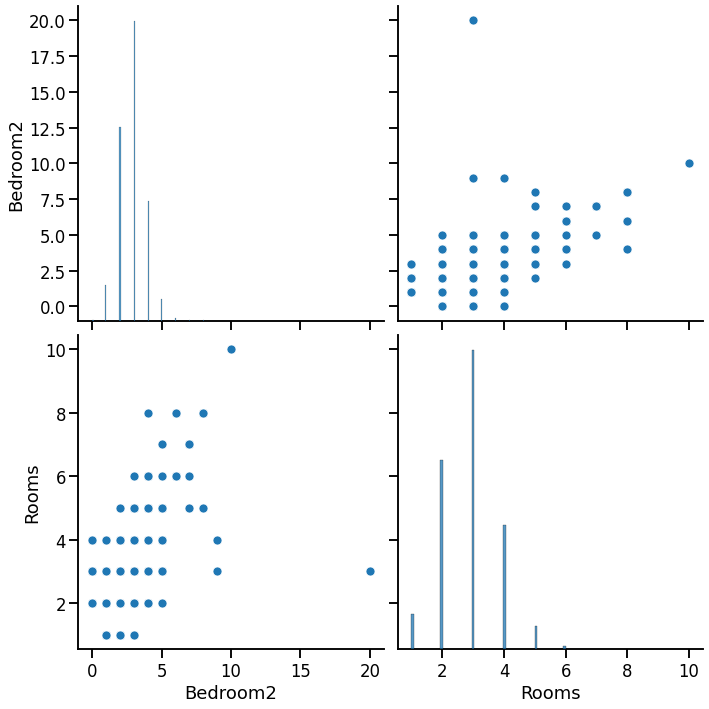

In [43]:
seaborn.pairplot(melb_df.loc[:,('Bedroom2','Rooms')],height=5)

En el segundo gráfico de la primer fila, podemos observar que la columna Bedroom2 poseería una correlación positiva con la columna Rooms.
Calcularemos el índice de correlación entre ambas para verificar esta interpretación.

`Los coeficientes de correlación lineal son estadísticos que cuantifican la asociación lineal entre dos variables numéricas. Su valor está comprendido en el rango [+1 , -1]. Siendo +1 una correlación positiva perfecta y -1 una correlación negativa perfecta.`

In [44]:
print('Correlacion: ',melb_df['Bedroom2'].corr(melb_df['Rooms']).round(2))

Correlacion:  0.94


El valor obtenido nos indica que el grado de asociación entre ellas es muy alto.

**Dado que la columna Bedroom2 no nos aporta información adocional a la columna Rooms y posee datos ruidosos, decidimos que el tratamiento adecuado es prescindir de la misma.**

Graficaremos la dispersión de la variable Rooms mediante un boxenplot.


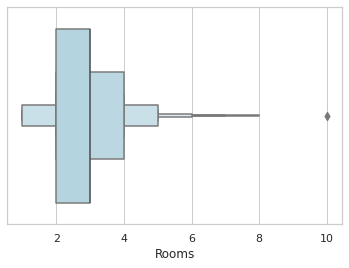

In [45]:
seaborn.set_theme(style="whitegrid")
seaborn.boxenplot(x=melb_df.Rooms,
                color='lightblue')
plt.ticklabel_format(style='plain', axis='x')
#plt.xticks(np.arange(1,10,step=1))


Observamos que la varible Rooms, tiene pocos valores mayores a 6, por lo que se podria agrupar todos estos valores atípicos y asignarles el valor 6, es decir asignar 6 a las propiedades que tienen 6, 7 ,8  y 10.


Cantidad de NaN: 0
Tipo de variable:  discreta
count   12342.00
mean        2.87
std         0.90
min         1.00
25%         2.00
50%         3.00
75%         3.00
max         6.00
Name: Rooms, dtype: float64


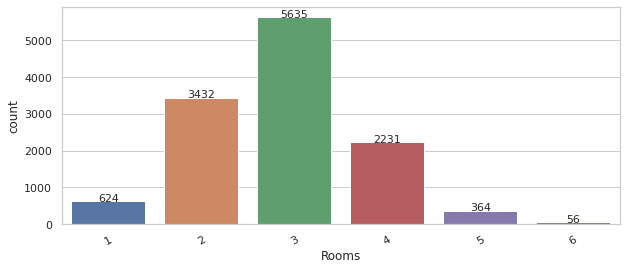

In [46]:
melb_df_filtrado.loc[(melb_df_filtrado['Rooms']>6),'Rooms']=6
estudio(melb_df_filtrado['Rooms'],out=0,n=9,size=(10,4))


##### Analisis de **BATHROOM**

Graficamos la distribución de frecuencias de la variable mediante un gráfico de barras.

Cantidad de NaN: 0
Tipo de variable:  discreta
count   12968.00
mean        1.49
std         0.64
min         0.00
25%         1.00
50%         1.00
75%         2.00
max         8.00
Name: Bathroom, dtype: float64


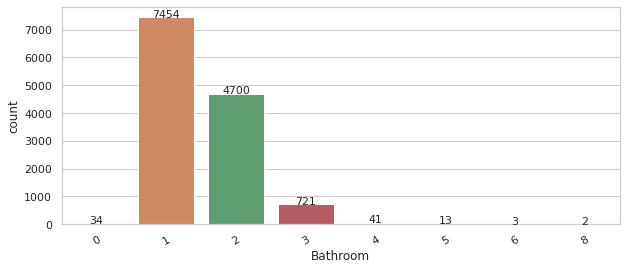

In [47]:
estudio(melb_df['Bathroom'],out=0,n=10,size=(10,4))

**Observamos que 33 propiedades tiene el valor 0 para la variable Bathroom que pueden estar derivados de un error de codificación, ya que todas las propiedades deberian tener al menos 1.**


**Observamos tambien que las propiedades con una cantidad de baños superior a 4 son muy poco frecuentes.**

Graficamos la dispersión de la variable Bathrooom mediante un boxenplot.

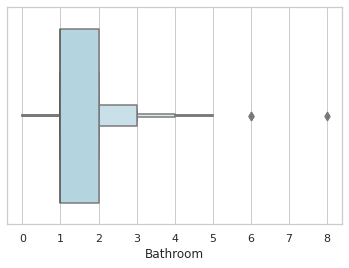

In [48]:
seaborn.set_theme(style="whitegrid")
seaborn.boxenplot(x=melb_df.Bathroom,
                color='lightblue')
plt.ticklabel_format(style='plain', axis='x')


**Al igual que hicimos con la columna Rooms, decidimos agrupar los valores atípicos (5,6,7 y 8) asignándoles el valor maximo 4. 
Además decidimos asignar a las observaciones sin baños el valor minímo 1, que se corresponde a su vez con la moda de la distribución de esta variable.**

In [49]:
moda= melb_df.Bathroom.mode()
print('MODA: ', moda.to_string(index=False))

MODA:   1


Cantidad de NaN: 0
Tipo de variable:  discreta
count   12342.00
mean        1.47
std         0.61
min         1.00
25%         1.00
50%         1.00
75%         2.00
max         4.00
Name: Bathroom, dtype: float64


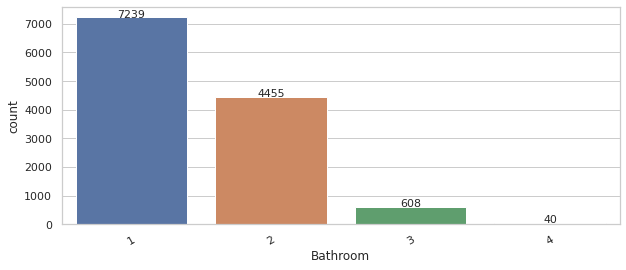

In [50]:
melb_df_filtrado.loc[(melb_df_filtrado['Bathroom']>4),'Bathroom']=4
melb_df_filtrado.loc[(melb_df_filtrado['Bathroom']==0),'Bathroom']=1

estudio(melb_df_filtrado['Bathroom'],out=0,n=9,size=(10,4))

Luego del análisis de Rooms y Bathroom decidimos hacer una validación extra mediante una crosstab, comparando la cantidad de habitaciones respecto a la cantidad de baños con el objeto de detectar casos atipicos y observamos que NO los hay, ya que solo hay 17 casos en los que la cantidad de baños supera por 1 unidad a la cantidad de habitaciones y podria explicarse por la existencia de un baño de visitas o servicio.


In [51]:
pandas.crosstab(melb_df_filtrado.Rooms, melb_df_filtrado.Bathroom,margins = True) 

Bathroom,1,2,3,4,All
Rooms,,,,,
1,619,5,0,0,624
2,2985,440,7,0,3432
3,3190,2312,128,5,5635
4,427,1479,310,15,2231
5,16,200,135,13,364
6,2,19,28,7,56
All,7239,4455,608,40,12342


##### Analisis de **Car**

Graficamos la distribución de frecuencias de la variable mediante un gráfico de barras.

Cantidad de NaN: 59
Tipo de variable:  discreta
count   12909.00
mean        1.58
std         0.95
min         0.00
25%         1.00
50%         2.00
75%         2.00
max        10.00
Name: Car, dtype: float64


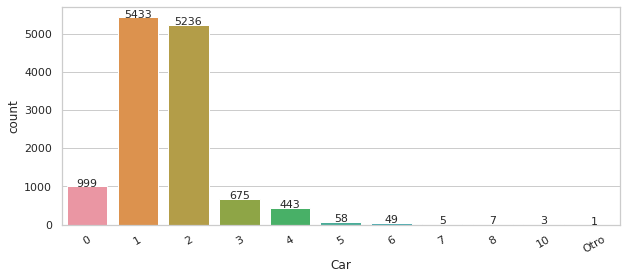

In [52]:
estudio(melb_df['Car'],out=0,n=11,size=(10,4))

**Observamos que esta variable tiene muchos valores NaN que podrian atribuirse a que no tienen espacio para auto y no se puso ningun valor, por lo que se le va a asignar 0.**


In [53]:
melb_df_filtrado.loc[(melb_df_filtrado['Car'].isna()),'Car']=0

print('Cantidad de nulos: ',melb_df_filtrado.Car.isna().sum())

Cantidad de nulos:  0


**También se observa que hay pocas propiedades con más de 5 y 6 lugares por lo que se van a agrupar para evitar outliers.**

In [54]:
melb_df_filtrado.loc[(melb_df_filtrado['Car']> 4),'Car']=5

Cantidad de NaN: 0
Tipo de variable:  discreta
count   12342.00
mean        1.56
std         0.91
min         0.00
25%         1.00
50%         1.00
75%         2.00
max         5.00
Name: Car, dtype: float64


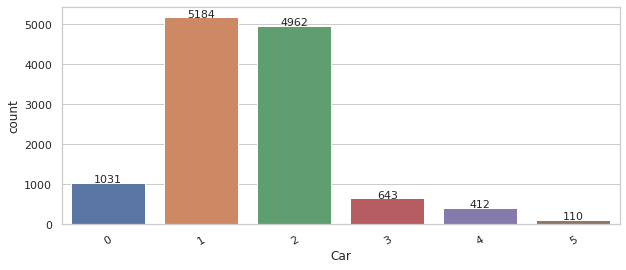

In [55]:
estudio(melb_df_filtrado['Car'],out=0,n=11,size=(10,4))

##### Analisis de **Distance**

Graficamos la distribución de frecuencias de las variables mediante un histograma y analizaremos su dispersión con un boxplot.

Cantidad de NaN: 0
Tipo de variable:  continua
count   12968.00
mean       10.24
std         5.94
min         0.00
25%         6.20
50%         9.40
75%        13.00
max        48.10
Name: Distance, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <a list of 50 Text major ticklabel objects>)

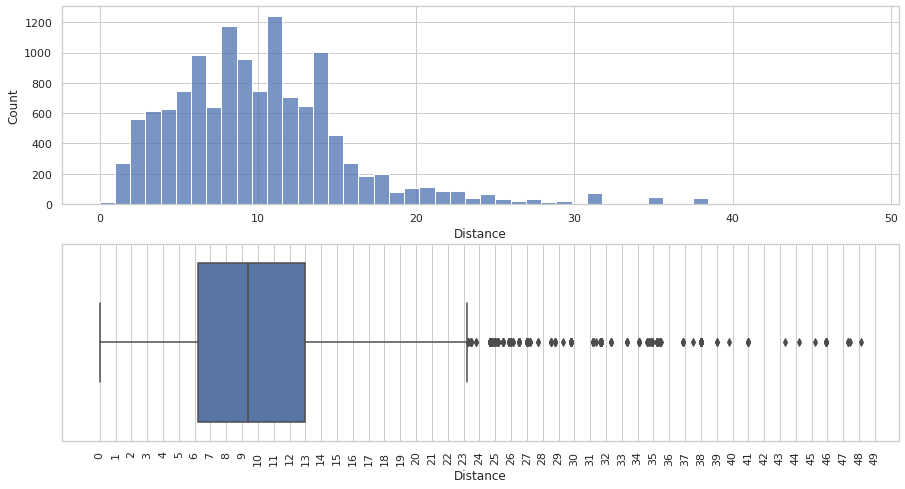

In [56]:
#Variable medida en kilómetros
estudio(melb_df['Distance'],out=0,size=(15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(np.arange(melb_df['Distance'].min(),melb_df['Distance'].max()+1,step=1))
plt.xticks(rotation=90)

Analizamos el boxplot.

In [57]:
q1=melb_df['Distance'].quantile([.25])
boxanalisis(melb_df['Distance'])

Q1:  [6.2]
Q3:  [13.]
IQR:  [6.8]
Limite Inferior Teorico:  [-4.]
Valor MIN:  0.0
Limite Superior Teorico:  [23.2]
Valor MAX:  48.1
El limite SUPERIOR (bigote derecho) de los datos sin considerar valores atípicos es:  [23.2]
El limite INFERIOR (bigote izquierdo) de los datos sin considerar valores atípicos es:  0.0


**De la gráfica observada y los valores obtenidos, podemos determinar que no existen valores atípicos en el extremo inferior. Si existen valores atípicos más allá del límite superior establecido en 23,2 Km. En este caso no vamos a tomar acción, ya que evaluaremos la relevancia de esta columna en el siguiente ejercicio.**

##### Analisis de variables categoricas

Graficamos la distribución de frecuencias de cada variable y pudismo observar que excepto Type y Method, todas ellas poseen una cantidad alta de categorías y pocas observaciones en cada una de ellas.
En el siguiente punto analizaremos las que consideraremos relevantes o no para la determinación del precio.


 Suburb 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 314

 Address 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 12782

 Type 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 3

 Method 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 5

 SellerG 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 265

 Postcode 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 198

 CouncilArea 

Cantidad de NaN: 1289
Tipo de variable:  categoria
Cantidad de valores unicos: 34

 Regionname 

Cantidad de NaN: 0
Tipo de variable:  categoria
Cantidad de valores unicos: 8


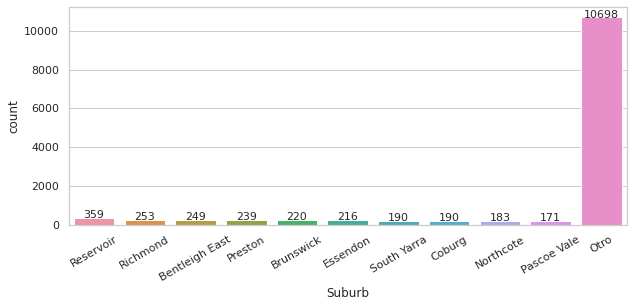

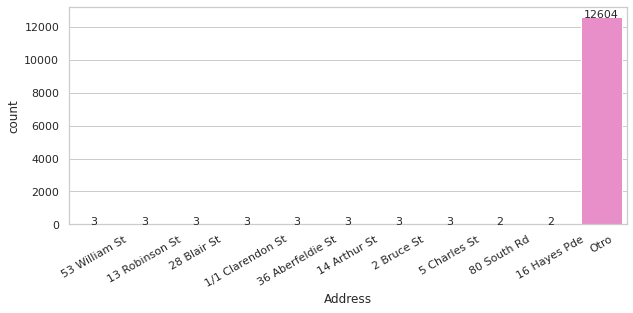

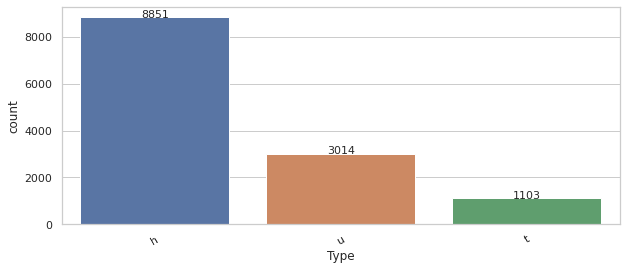

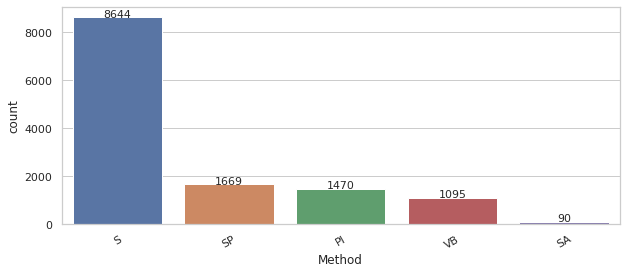

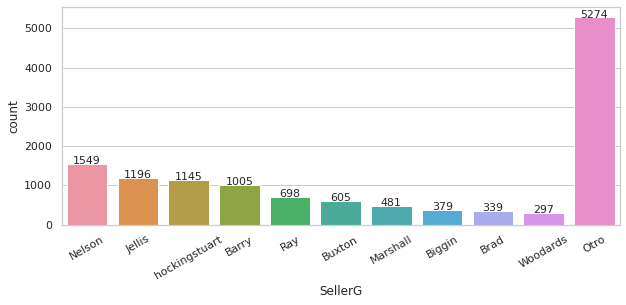

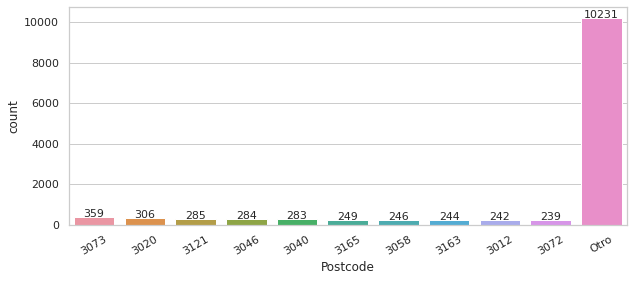

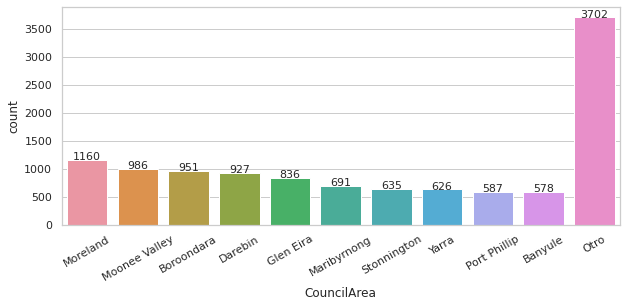

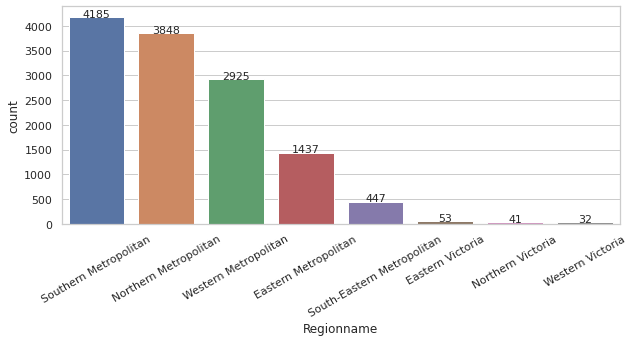

In [58]:
for i in categoricas:
  print('\n',i,'\n')
  estudio(melb_df[i],out=0,n=11,size=(10,4))

### **2.Investigar la distribución de las variables del conjunto de datos y seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad.**
  1. Justificar cada columna no seleccionada.
  2. Para las variables categóricas seleccionadas, agrupe o combine las categorías poco frecuentes para asegurar que todos los grupos tengan un número mínimo de registros.

Validamos el tamaño de nuestro dataset, posterior al tratamiento de valores atípicos realizados.

In [59]:
print('Cantidad de registros Dataset', len(melb_df_filtrado.index))

Cantidad de registros Dataset 12342


Validamos las columnas con datos faltantes.

In [60]:
melb_df_filtrado.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea     6010
YearBuilt        4991
CouncilArea      1221
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
date                0
dtype: int64

In [61]:
melb_df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12342 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         12342 non-null  category      
 1   Address        12342 non-null  category      
 2   Rooms          12342 non-null  int8          
 3   Type           12342 non-null  category      
 4   Price          12342 non-null  float64       
 5   Method         12342 non-null  category      
 6   SellerG        12342 non-null  category      
 7   Date           12342 non-null  object        
 8   Distance       12342 non-null  float64       
 9   Postcode       12342 non-null  category      
 10  Bedroom2       12342 non-null  int8          
 11  Bathroom       12342 non-null  int8          
 12  Car            12342 non-null  Int8          
 13  Landsize       12342 non-null  float64       
 14  BuildingArea   6332 non-null   float64       
 15  YearBuilt      7351

####**Analisis de Precio y variables que informan ubicación geográfica**

Las variables que brindan información de la ubicación de la propiedad son:

1.   Suburb (Cualitativa)
2.   Address (Cualitativa)
3.   Distance (Cuantitativa)
4.   Postcode (Cualitativa)
5.   CouncilArea (Cualitativa)
6.   Lattitude (Cuantitativa)
7.   Longtitude (Cuantitativa)
8.   Regionname (Cualitativa)



#####**ADDRESS**

Consideramos que **la variable Address no será tenida en cuenta** porque es un valor categorico casi unico para cada propiedad y sería mejor utilizar otras variables para definir una ubicacion.

In [62]:
print('Cantidad de categorías en la columna Address', len(melb_df_filtrado['Address'].unique()))
print('Cantidad de registros Dataset', len(melb_df_filtrado.index))


Cantidad de categorías en la columna Address 12167
Cantidad de registros Dataset 12342


#####**DISTANCIA**

Respecto a la variable Distance, que representa la distancia en kilómetros al Melbourne Central Business district (CBD), calculamos el indice de correlación

In [63]:
print('Correlacion: ',melb_df_filtrado['Price'].corr(melb_df_filtrado['Distance']).round(2))

Correlacion:  -0.18


El indice de correlación negativo nos indica que las dos variables, Precio y Distancia al CBD, tienen tendencias contrarias y el valor cercano a 0 nos sugiere que la relación entre dos variables es escasa.

Decidimos entonces que la **variable Distancia no será tenida en cuenta.**

#####**REGIONNAME**

Melbourn se encuentra en el estado de Victoria y este se divide en ocho regiones electorales, 3 rurales y 5 metropolitanas:

<img src=https://upload.wikimedia.org/wikipedia/commons/c/c0/Regions_of_Legislative_Council%2C_Victoria.svg width="400" height="300">

In [64]:
print('Cantidad de categorías en la columna Regionname: ', len(melb_df_filtrado['Regionname'].unique()))

Cantidad de categorías en la columna Regionname:  8


Obtenemos la tabla de frecuencias de las diferentes regiones.

In [65]:
melb_df_filtrado['Regionname'].value_counts()

Southern Metropolitan         3955
Northern Metropolitan         3690
Western Metropolitan          2819
Eastern Metropolitan          1346
South-Eastern Metropolitan     425
Eastern Victoria                42
Northern Victoria               34
Western Victoria                31
Name: Regionname, dtype: int64

Esta variable cualitativa, por lo que analizaremos la relación entre la misma y la variable Price mediante un test no paramétrico.

Sabemos que cada propiedad pertenece de manera exclusiva a una categoria específica, por lo que si dividimos los datos entre las categorias, resultan muestras independientes. Teniendo en cuenta esto, vamos a selecionar arbitrariamente las regiones con mayor frecuencia "Southern Metropolitan" y "Northern Metropolitan" para extraer las dos muestras necesarias para realizar el Mann-Whitney U Test.

In [66]:
# Getting our data in to a dictionary
data_reg = {'Southern Metropolitan':list(melb_df_filtrado[melb_df_filtrado.Regionname == 'Southern Metropolitan']['Price'].sample(n=3600, random_state=1, replace=True)),
        'Northern Metropolitan':list(melb_df_filtrado[melb_df_filtrado.Regionname == 'Northern Metropolitan']['Price'].sample(n=3600, random_state=1, replace=True))}

# Dictionary to Dataframe
df_regions = pandas.DataFrame(data_reg)
df_regions

,Southern Metropolitan,Northern Metropolitan
0,1750000.00,358500.00
1,2130000.00,1315000.00
2,660000.00,1040000.00
3,1230000.00,1325000.00
4,817500.00,425000.00
...,...,...
3595,815000.00,1315000.00
3596,855000.00,390000.00
3597,2117000.00,605000.00
3598,360000.00,530000.00


El supuesto predeterminado o hipótesis nula H0 es que no hay diferencia entre las distribuciones de las muestras de datos.

In [67]:
from scipy.stats import mannwhitneyu

# compare samples
stat, p = mannwhitneyu(df_regions['Southern Metropolitan'], df_regions['Northern Metropolitan'])
print('Estadístico: ', stat, 'p-valor: ' ,p)
# interpretación
alpha = 0.05
if p > alpha:
	print('Misma Distribución (No podemos rechazar H0)')
else:
	print('Diferente Distribución (Rechazamos H0)')

Estadístico:  4408176.0 p-valor:  2.378679782558358e-122
Diferente Distribución (Rechazamos H0)


Graficamos la relación entre la variable Price y Regionname.

['Northern Metropolitan', 'Western Metropolitan', 'Southern Metropolitan', 'Eastern Metropolitan', 'South-Eastern Metropolitan', 'Eastern Victoria', 'Northern Victoria', 'Western Victoria']
Categories (8, object): ['Northern Metropolitan', 'Western Metropolitan', 'Southern Metropolitan',
                         'Eastern Metropolitan', 'South-Eastern Metropolitan', 'Eastern Victoria',
                         'Northern Victoria', 'Western Victoria']


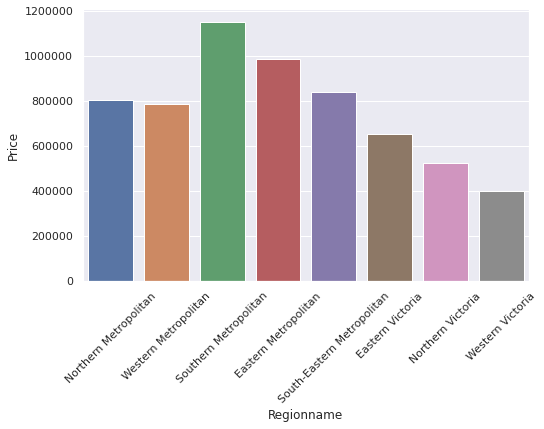

In [68]:
from numpy import median

df_col=melb_df_filtrado['Regionname']
categorias=df_col.unique()
print (categorias)

plt.figure(figsize=(8,5))
seaborn.set(style="darkgrid")
catorder=['Northern Metropolitan', 'Western Metropolitan', 'Southern Metropolitan',
                         'Eastern Metropolitan', 'South-Eastern Metropolitan', 'Eastern Victoria',
                         'Northern Victoria', 'Western Victoria']
grafico= seaborn.barplot(y="Price", data=melb_df_filtrado, x='Regionname', order=catorder, estimator=median, ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()


#####**SUBURB**

La cantidad de categorías de los suburbios contenidos en el dataset son 308. 

In [69]:
print('Cantidad de categorías en la columna Suburb', len(melb_df_filtrado['Suburb'].unique()))

Cantidad de categorías en la columna Suburb 308


In [70]:
#Observamos los 20 primeros suburbios con mayor cantidad de propiedades relevadas
melb_df_filtrado['Suburb'].value_counts()[:50]

Reservoir            350
Bentleigh East       241
Preston              232
Richmond             232
Brunswick            214
Essendon             210
Coburg               184
Northcote            181
South Yarra          176
Pascoe Vale          167
Yarraville           162
Glenroy              156
Glen Iris            156
Hawthorn             154
Carnegie             142
Moonee Ponds         141
St Kilda             140
Balwyn North         138
Thornbury            136
Newport              133
Port Melbourne       131
Bentleigh            130
Footscray            126
Kew                  124
Brighton             123
Ascot Vale           123
Elwood               120
Keilor East          119
Brighton East        119
Prahran              113
Sunshine             109
Doncaster            108
Brunswick West       105
Kensington           102
Surrey Hills         102
Fawkner              101
West Footscray       101
Malvern East          98
Hampton               95
Camberwell            94


**Cada uno de estos suburbios pertenece exclusivamente a una Región, con lo cual creemos que la columna Regionname es una agrupación adecuada de suburbios y podría utilizarse ya que posee menor cantidad de clases o categorías.**

In [71]:
regions=melb_df_filtrado['Regionname'].unique()
num_rows=len(melb_df_filtrado['Regionname'].unique())

for r in range(0,8):
  item_reg= regions[r]
  df_item=melb_df_filtrado[melb_df_filtrado.Regionname==item_reg]
  print('REGIÓN: ',item_reg)
  print('Cantidad Suburbios: ',len(df_item.Suburb.unique()))
 

REGIÓN:  Northern Metropolitan
Cantidad Suburbios:  58
REGIÓN:  Western Metropolitan
Cantidad Suburbios:  70
REGIÓN:  Southern Metropolitan
Cantidad Suburbios:  61
REGIÓN:  Eastern Metropolitan
Cantidad Suburbios:  53
REGIÓN:  South-Eastern Metropolitan
Cantidad Suburbios:  38
REGIÓN:  Eastern Victoria
Cantidad Suburbios:  14
REGIÓN:  Northern Victoria
Cantidad Suburbios:  10
REGIÓN:  Western Victoria
Cantidad Suburbios:  4


In [72]:
label_freq = melb_df_filtrado['Suburb'].value_counts() / len(melb_df_filtrado)
print(label_freq)

Reservoir          0.03
Bentleigh East     0.02
Preston            0.02
Richmond           0.02
Brunswick          0.02
                   ... 
New Gisborne       0.00
Monbulk            0.00
Riddells Creek     0.00
Bullengarook       0.00
North Warrandyte   0.00
Name: Suburb, Length: 314, dtype: float64


In [73]:
frequencies = melb_df_filtrado['Suburb'].value_counts(normalize=True, ascending=False)
#print(frequencies)

mapping= melb_df_filtrado['Suburb'].map(frequencies)
#print(mapping)
#threshold = frequencies[(frequencies.cumsum() > 0.1).idxmax()]

In [74]:
#melb_df_filtrado['Suburb'].mask(melb_df['Suburb'].map(melb_df['Suburb'].value_counts(normalize=True)) < threshold, 'Other')

#####**COUNCILAREA**

Los consejos locales brindan una amplia variedad de servicios a sus municipios y hacen cumplir las leyes federales, estatales y locales.

In [75]:
print('Cantidad de categorías en la columna CouncilArea: ', len(melb_df_filtrado['CouncilArea'].unique()))


Cantidad de categorías en la columna CouncilArea:  34


In [76]:
print('Cantidad de NULOS en la columna CouncilArea', melb_df_filtrado['CouncilArea'].isna().sum())

Cantidad de NULOS en la columna CouncilArea 1221


In [77]:
#Observamos la cantidad de propiedades relevadas por categoria de CouncilArea
melb_df_filtrado['CouncilArea'].value_counts()[:34]

Moreland             1134
Moonee Valley         947
Darebin               905
Boroondara            890
Glen Eira             809
Maribyrnong           662
Stonnington           599
Yarra                 583
Banyule               553
Port Phillip          545
Brimbank              416
Hobsons Bay           412
Melbourne             404
Bayside               379
Monash                319
Whitehorse            283
Manningham            281
Kingston              197
Hume                  160
Whittlesea            159
Wyndham                83
Maroondah              73
Knox                   71
Melton                 63
Greater Dandenong      51
Frankston              48
Casey                  35
Nillumbik              34
Yarra Ranges           14
Cardinia                6
Macedon Ranges          4
Moorabool               1
Unavailable             1
Name: CouncilArea, dtype: int64

**Observamos que si bien la cantidad de categorias parece ser reducida, la mayor parte de las observaciones poseen el valor nulo en dicha columna, con lo cual no es representativo/confiable el valor obtenido**.

Nuevamente estudiamos la relación entre los consejos y las regiones electorales y debido a la gran cantidad de nulos, podemos decir que la columna Regionname enos brindará mayor información.

In [78]:
regions=melb_df_filtrado['Regionname'].unique()
num_rows=len(melb_df_filtrado['Regionname'].unique())

for r in range(0,8):
  item_reg= regions[r]
  df_item=melb_df_filtrado[melb_df_filtrado.Regionname==item_reg]
  print('REGIÓN: ',item_reg)
  print('=> Cantidad C. Area: ',len(df_item.CouncilArea.unique()))
  print('=> Cantidad NULOS:   ',df_item.CouncilArea.isna().sum())

REGIÓN:  Northern Metropolitan
=> Cantidad C. Area:  10
=> Cantidad NULOS:    324
REGIÓN:  Western Metropolitan
=> Cantidad C. Area:  9
=> Cantidad NULOS:    266
REGIÓN:  Southern Metropolitan
=> Cantidad C. Area:  11
=> Cantidad NULOS:    271
REGIÓN:  Eastern Metropolitan
=> Cantidad C. Area:  9
=> Cantidad NULOS:    219
REGIÓN:  South-Eastern Metropolitan
=> Cantidad C. Area:  7
=> Cantidad NULOS:    117
REGIÓN:  Eastern Victoria
=> Cantidad C. Area:  6
=> Cantidad NULOS:    7
REGIÓN:  Northern Victoria
=> Cantidad C. Area:  6
=> Cantidad NULOS:    11
REGIÓN:  Western Victoria
=> Cantidad C. Area:  3
=> Cantidad NULOS:    6


#####**LATTITUDE Y LONGTITUDE**

Estas variables son cuantitaivas numéricas, pero representan coordenadas, por lo que su significado esta dado por el punto que forman ambos valores para la propiedad observada. Al igual que sucede con la columna Adress, las coordenadas representan la ubicación específica de la propiedad y por tanto tendremos casi tantos puntos de ubicación como propiedades del dataset.
**No consideramos significativo el aporte de información de estas columnas.**

In [79]:
print('Cantidad de valores únicos en la columna Lattitude: ', len(melb_df_filtrado['Lattitude'].unique()))
print('Cantidad de valores únicos en la columna Longtitude: ', len(melb_df_filtrado['Longtitude'].unique()))

Cantidad de valores únicos en la columna Lattitude:  6131
Cantidad de valores únicos en la columna Longtitude:  6655


#####**POSTCODE**

Los códigos postales australianos constan de cuatro dígitos y se utilizan para clasificar y enrutar el correo de manera más eficiente dentro del sistema postal australiano.
Algunos cubren grandes poblaciones, mientras que otros poblaciones mucho más pequeñas, incluso en áreas urbanas.
Algunos lugares de Australia no tienen códigos postales, mientras algunas ciudades y suburbios tienen dos códigos postales: uno para entregas en la calle y otro para apartados de correos.
Los primeros uno o dos números suelen mostrar el estado o territorio al que pertenece el código postal.
Como dijimos, Melbourne pertenece a Vicotira y el rango de postcodes alli es 3000-3999. 


In [80]:
print('Cantidad de categorías en la columna Postcode: ', len(melb_df_filtrado['Postcode'].unique()))

Cantidad de categorías en la columna Postcode:  194


In [81]:
print('Cantidad de NULOS en la columna Postcode', melb_df_filtrado['Postcode'].isna().sum())

Cantidad de NULOS en la columna Postcode 0


Teniendo en cuenta la información que proveen los postcodes, creemos conveniente agruparlos por rangos de X numeros consecutivos, ya que cada rango representaria un conjunto de areas aledañas.

In [82]:
melb_df=melb_df_filtrado.copy()

In [83]:
#primero convertimos el valor a entero, para facilitar el agrupamiento y reemplazo, luego convertiremos nuevamente en columna categorica
melb_df['Postcode'] = melb_df['Postcode'].astype(int) 


melb_df.loc[(melb_df['Postcode'] > 2999) & (melb_df['Postcode'] < 3100),'Postcode_Agrupado']=3099
melb_df.loc[(melb_df['Postcode'] > 3099) & (melb_df['Postcode'] < 3200),'Postcode_Agrupado']=3199
melb_df.loc[(melb_df['Postcode'] > 3199) & (melb_df['Postcode'] < 3300),'Postcode_Agrupado']=3299
melb_df.loc[(melb_df['Postcode'] > 3299) & (melb_df['Postcode'] < 3400),'Postcode_Agrupado']=3399
melb_df.loc[(melb_df['Postcode'] > 3399) & (melb_df['Postcode'] < 3500),'Postcode_Agrupado']=3499
melb_df.loc[(melb_df['Postcode'] > 3499) & (melb_df['Postcode'] < 3600),'Postcode_Agrupado']=3599
melb_df.loc[(melb_df['Postcode'] > 3599) & (melb_df['Postcode'] < 3700),'Postcode_Agrupado']=3699
melb_df.loc[(melb_df['Postcode'] > 3699) & (melb_df['Postcode'] < 3800),'Postcode_Agrupado']=3799
melb_df.loc[(melb_df['Postcode'] > 3799) & (melb_df['Postcode'] < 3900),'Postcode_Agrupado']=3899
melb_df.loc[(melb_df['Postcode'] > 3899) & (melb_df['Postcode'] < 4000),'Postcode_Agrupado']=3999


melb_df['Postcode_Agrupado'] = melb_df['Postcode_Agrupado'].astype('str') 
melb_df['Postcode_Agrupado'] = melb_df['Postcode_Agrupado'].astype('category') 

melb_df['Postcode_Agrupado'].unique()

['3099.0', '3299.0', '3199.0', '3899.0', '3999.0', '3799.0', '3499.0', '3399.0']
Categories (8, object): ['3099.0', '3299.0', '3199.0', '3899.0', '3999.0', '3799.0', '3499.0',
                         '3399.0']

Graficamos la relación entre la variable Price y la variable Postcode mediante un gráfico de barras.

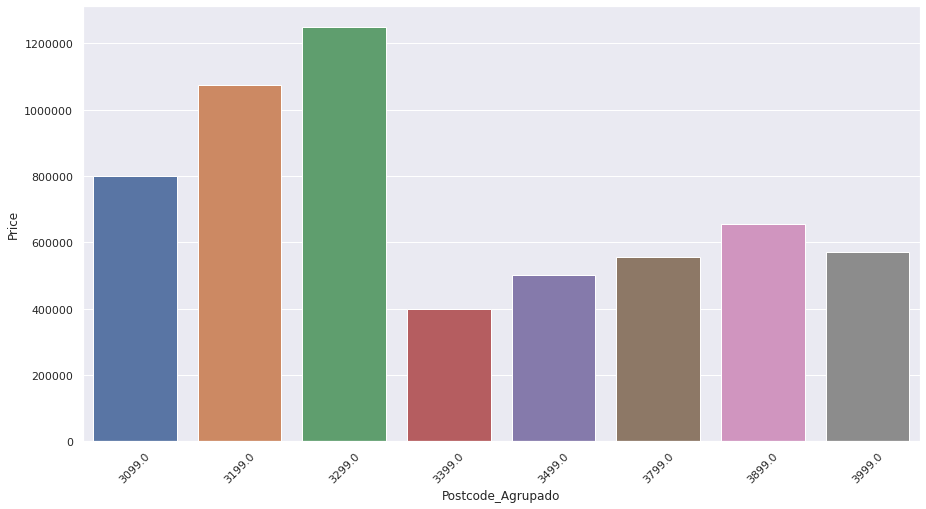

In [84]:
from numpy import median
df_col=melb_df['Postcode_Agrupado']
categorias=df_col.unique()
order_pc=['3099', '3199','3299','3399','3499','3599','3699','3799','3899','3999']
plt.figure(figsize=(15,8))
seaborn.set(style="darkgrid")
grafico= seaborn.barplot(y="Price", data=melb_df, x='Postcode_Agrupado', estimator=median, ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.show()

**Por ahora consideramos que Postcode es una variable a considerar por su relación con Price.**

####**Precio y variables que describen la propiedad**

Las variables que brindan información de las caraterísticas la propiedad son:


1.   Rooms (Cuantitativa)
2.   Bedroom2 (Cuantitativa)
3.   Bathroom (Cuantitativa)
4.   Car (Cuantitativa)
5.   Landsize (Cuantitativa)
6.   YearBuilt (Cuantitativa)
7.   BuildingArea (Cuantitativa)
8.   Type (Cualitativa)
9.   Propertycount (Cuantitativa)




Obtenemos la matriz de correlación para las variables cuantitativas.

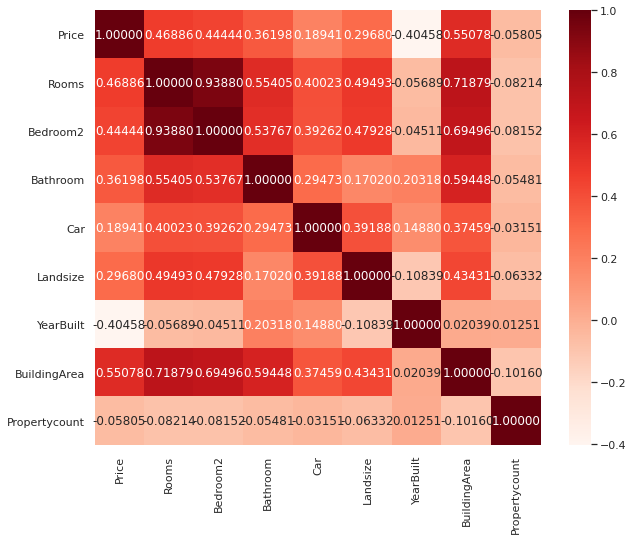

In [85]:
#Estudiando correlaciones entre variables cuantitativas
cols_descript_df = melb_df.loc[:,['Price','Rooms','Bedroom2','Bathroom','Car','Landsize','YearBuilt','BuildingArea','Propertycount']]

correlations= cols_descript_df.corr()


plt.figure(figsize=(10,8))

seaborn.heatmap(correlations, annot=True, cmap=plt.cm.Reds, fmt='.5f')
plt.show()


In [86]:
correlations[['Price']].sort_values(by = 'Price',ascending = False)\
.style.background_gradient()

,Price
Price,1.000000
BuildingArea,0.550784
Rooms,0.468857
Bedroom2,0.444439
Bathroom,0.361980
Landsize,0.296803
Car,0.189408
Propertycount,-0.058051
YearBuilt,-0.404584


En estas matrices de correlación se puede observar:

#####**ROMS Y BEDROOM2**

Como hemos comentado anteriormente en el ejercicio nº 1, estás dos variables están fuertemente correladas.Es por esto que sólo vamos a mantener una de estas variables en el análisis, **'Rooms'**, ya que está más correlacionada con 'Price' y no posee valores ruidosos.

#####**YEARBUILT Y BUILDINGAREA**

Respecto a la variable **YearBuilt**, el indice de correlación negativo nos indica que las dos variables, Precio y Año de construcción, tienen tendencias contrarias. También debemos recordar que presenta muchos valores faltantes, por lo que en caso de ser considerada, hay que efectuar un tratamiento de los mismos.

Respecto a la variable **BuildingArea**, el indice de correlación nos idica una fuerte correlación positiva, con lo cual es una variable a ser considerada.


#####**LANDSIZE**

Respecto a la variable **Landsize**, el indice de correlación nos idica una fuerte correlación positiva, con lo cual es una variable a ser considerada.

#####**BATHROOM y CAR**

El índice de correlación obtenido para la variable **Bathroom** nos indica una correlación positiva considerable, aunque menor a la obtenida para BuildingArea o Rooms. Decimos mantener esta variable bajo análisis.

En el caso de la variable **Car** el indice de correlación nos marca una leve relación positiva con la variable Precio. Decimos tambien mantener esta variable bajo análisis.

#####**PROPERTYCOUNT**

Respecto a la variable cuantitativa Propertycount, el indice de correlación negativo nos indica que las dos variables, Precio y Cantidad de propiedades del suburbio, tienen tendencias contrarias y el valor cercano a 0 nos sugiere que la relación entre dos variables es escasa.

**Decidimos entonces que la variable Propertycount no será tenida en cuenta.**

#####**TYPE**

La variable Type es una variable cualitativa que posee pocas categorías.

In [87]:
print('Cantidad de categorías en la columna Type: ', len(melb_df['Type'].unique()))

Cantidad de categorías en la columna Type:  3


In [88]:
print('Categorías en la columna Type: ', melb_df['Type'].unique())

Categorías en la columna Type:  ['h', 'u', 't']
Categories (3, object): ['h', 'u', 't']


Obtenemos la tabla de frecuencias de los diferentes tipos de propiedad.

In [89]:
melb_df['Type'].value_counts()

h    8510
u    2758
t    1074
Name: Type, dtype: int64

Esta variable cualitativa, por lo que analizaremos la relación entre la misma y la variable Price mediante un test no paramétrico.

Sabemos que cada propiedad pertenece de manera exclusiva a una categoria específica, por lo que si dividimos los datos entre las categorias, resultan muestras independientes.
Teniendo en cuenta esto, vamos a selecionar arbitrariamente los tipos "h" y "u" para extraer las dos muestras necesarias para realizar el Mann-Whitney U Test. 

In [90]:
# Getting our data in to a dictionary
data = {'u':list(melb_df[melb_df.Type == 'u']['Price'].sample(n=2000, random_state=1, replace=True)),
        'h':list(melb_df[melb_df.Type == 'h']['Price'].sample(n=2000, random_state=1, replace=True))}

# Dictionary to Dataframe
df = pandas.DataFrame(data)
df

,u,h
0,500000.00,1100000.00
1,600000.00,675000.00
2,1400000.00,1890000.00
3,671000.00,1750000.00
4,335000.00,1226000.00
...,...,...
1995,510000.00,1500000.00
1996,995000.00,883300.00
1997,674000.00,1400000.00
1998,700500.00,955000.00


El supuesto predeterminado o hipótesis nula H0 es que no hay diferencia entre las distribuciones de las muestras de datos.

In [91]:
from scipy.stats import mannwhitneyu

# compare samples
stat, p = mannwhitneyu(df['u'], df['h'])
print('Estadístico: ', stat, 'p-valor: ' ,p)
# interpretación
alpha = 0.05
if p > alpha:
	print('Misma Distribución (No podemos rechazar H0)')
else:
	print('Diferente Distribución (Rechazamos H0)')

Estadístico:  563582.5 p-valor:  0.0
Diferente Distribución (Rechazamos H0)


**Concluímos entonces que existe una correlación entre la variable Price y la variable Type, por lo que no prescindiremos de esta columa.**

Graficamos la relación entre la variable Price y Type.

['h', 'u', 't']
Categories (3, object): ['h', 'u', 't']


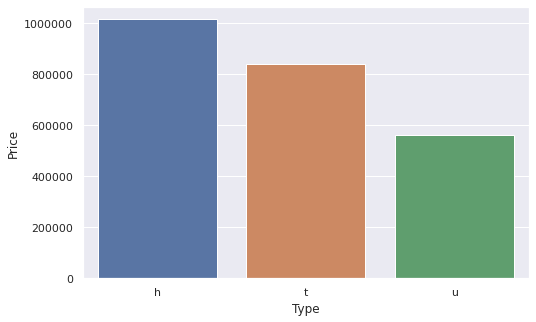

In [92]:
from numpy import median
df_col=melb_df['Type']
categorias=df_col.unique()
print (categorias)

plt.figure(figsize=(8,5))
seaborn.set(style="darkgrid")
catorder=['h', 't', 'u']
grafico= seaborn.barplot(y="Price", data=melb_df, x='Type', order=catorder, estimator=median, ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.show()

####**Precio y variables que describen la transacción inmobiliaria**

Las variables que brindan información sobre la venta de la propiedad son:


1.   Method (Cualitativa)
2.   SellerG (Cualitativa)
3.   Date (Cuantitativa)

#####**SELLERG**



La variable **SellerG** es una variable categorica de muchos valores posibles y el vendedor no deberia ser un factor importante en el precio de la propiedad.


In [93]:
print('Cantidad de categorías en la columna SellerG: ', len(melb_df['SellerG'].unique()))

Cantidad de categorías en la columna SellerG:  261


**Decidimos no considerar en el análisis esta variable.**

#####**METHOD**

La variable Method es una variable cualitativa que posee pocas categorías.

In [94]:
print('Cantidad de categorías en la columna Method: ', len(melb_df['Method'].unique()))

Cantidad de categorías en la columna Method:  5


In [95]:
print('Categorías en la columna Method: ', melb_df['Method'].unique())

Categorías en la columna Method:  ['S', 'SP', 'PI', 'VB', 'SA']
Categories (5, object): ['S', 'SP', 'PI', 'VB', 'SA']


Obtenemos la tabla de frecuencias de los diferentes metodos.

In [96]:
melb_df['Method'].value_counts()

S     8290
SP    1588
PI    1364
VB    1014
SA      86
Name: Method, dtype: int64

Esta variable cualitativa, por lo que analizaremos la relación entre la misma y la variable Price mediante un test no paramétrico.

Sabemos que cada propiedad pertenece de manera exclusiva a una categoria específica, por lo que si dividimos los datos entre las categorias, resultan muestras independientes. Teniendo en cuenta esto, vamos a selecionar arbitrariamente los métodos "SP" y "S" para extraer las dos muestras necesarias para realizar el Mann-Whitney U Test.

In [97]:
# Getting our data in to a dictionary
data_methods = {'SP':list(melb_df[melb_df.Method == 'SP']['Price'].sample(n=1300, random_state=1, replace=True)),
        'S':list(melb_df[melb_df.Method == 'S']['Price'].sample(n=1300, random_state=1, replace=True))}

# Dictionary to Dataframe
df_methods = pandas.DataFrame(data_methods)
df_methods

,SP,S
0,452000.00,1665000.00
1,545000.00,1040000.00
2,472000.00,976000.00
3,275000.00,1285000.00
4,440000.00,1010000.00
...,...,...
1295,901000.00,470000.00
1296,981000.00,2260000.00
1297,1515000.00,840000.00
1298,995000.00,1220000.00


El supuesto predeterminado o hipótesis nula H0 es que no hay diferencia entre las distribuciones de las muestras de datos.

In [98]:
from scipy.stats import mannwhitneyu

# compare samples
stat, p = mannwhitneyu(df_methods['SP'], df_methods['S'])
print('Estadístico: ', stat, 'p-valor: ' ,p)
# interpretación
alpha = 0.05
if p > alpha:
	print('Misma Distribución (No podemos rechazar H0)')
else:
	print('Diferente Distribución (Rechazamos H0)')

Estadístico:  663343.0 p-valor:  1.1395472366564338e-21
Diferente Distribución (Rechazamos H0)


**Concluímos entonces que existe una correlación entre la variable Price y la variable Method, por lo que no vamos a prescindir de esta columna.**

Graficamos la relación entre la variable Price y Method (medianas).

['S', 'SP', 'PI', 'VB', 'SA']
Categories (5, object): ['S', 'SP', 'PI', 'VB', 'SA']


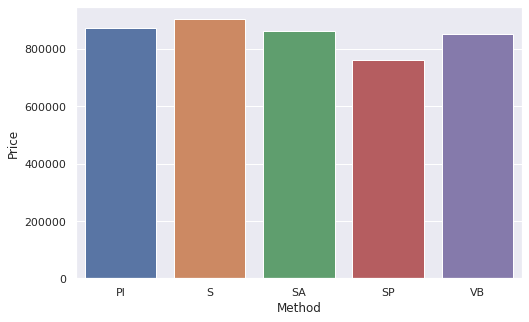

In [99]:
from numpy import median
df_col=melb_df['Method']
categorias=df_col.unique()
print (categorias)

plt.figure(figsize=(8,5))
seaborn.set(style="darkgrid")
catorder=['PI', 'S', 'SA','SP','VB']
grafico= seaborn.barplot(y="Price", data=melb_df, x='Method', order=catorder, estimator=median, ci=None)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=0)
plt.show()

#####**DATE** 
**Prueba de Dickey Fuller Aumentada** sobre la columna precio para saber si existe estacionalidad

Aplicamos la prueba sobre el Precio de las propiedades para saber si permanece estacionario respecto al tiempo y así eliminar la columna DATE de nuestro DataFrame

In [100]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [101]:
adf_precio=adfuller(melb_df['Price'], maxlag=1 )
print('El T-Test es:     ', adf_precio[0])

El T-Test es:      -58.37208885536188


Observamos en este caso que el valor obtenido es -57.84.
Sabemos por la teoría que cuanto más negativo sea este valor, es más probable que rechacemos la hipótesis nula (tenemos un conjunto de datos estacionario).

Obtenemos el P-value. Este valor nos indica la probabilidad de que la hipótesis nula no sea rechazada.

In [102]:
print('El p-value es: ', adf_precio[1])

El p-value es:  0.0


En nuestro test tenemos que el P-value es 0, por lo tanto, existe una probabilidad del 0% de que nuestra serie temporal sea no estacionaria.

Obtenemos los valores críticos para un intervalo de confianza del 1%, del 5% y del 10%.

In [103]:
print('Valores Críticos: ', adf_precio[4])

Valores Críticos:  {'1%': -3.430880037343061, '5%': -2.8617742498682963, '10%': -2.56689468619398}


Podemos ver que nuestro valor estadístico de -57.84 es menor que el valor de -3,430 al 1%, menor que el valor -2.861 al 5% y menor que el valor -2.56 al 10%.

Esto sugiere que podemos rechazar la hipótesis nula con un nivel de significancia de menos del 1% (es decir, una baja probabilidad de que el resultado sea una casualidad estadística).

**Finalmente decidimos excluir la variable Date del análisis.**

####**Variables a Excluir**


Text(0.5, 1.0, 'Cardinality')

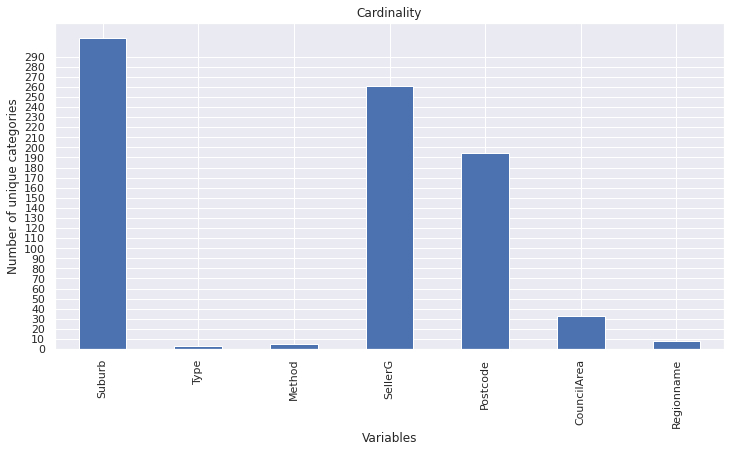

In [104]:
df_categorical= melb_df[['Suburb','Type','Method','SellerG','Postcode','CouncilArea','Regionname']]
df_categorical.nunique().plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.yticks(np.arange(0,300,step=10))
plt.xlabel('Variables')
plt.title('Cardinality')

In [105]:
excluir={'Address','Distance', 'Bedroom2','Propertycount','SellerG',  'Date'}
col=melb_df.columns.isin(excluir)
df=melb_df.loc[:,~col]
df.head(3)



,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,date,Postcode_Agrupado
0,Abbotsford,2,h,1480000.00,S,3067,1,1,202.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2016-03-12,3099.0
1,Abbotsford,2,h,1035000.00,S,3067,1,0,156.00,79.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-02,3099.0
2,Abbotsford,3,h,1465000.00,SP,3067,2,0,134.00,150.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2017-04-03,3099.0


### 3.Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  #### a.Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.


In [106]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22895 entries, 0 to 22894
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   description            22563 non-null  object 
 1   neighborhood_overview  14424 non-null  object 
 2   street                 22895 non-null  object 
 3   neighborhood           17082 non-null  object 
 4   city                   22895 non-null  object 
 5   suburb                 22872 non-null  object 
 6   state                  22834 non-null  object 
 7   zipcode                22753 non-null  object 
 8   latitude               22895 non-null  float64
 9   longitude              22895 non-null  float64
 10  price                  22895 non-null  int64  
 11  weekly_price           2524 non-null   float64
 12  monthly_price          1891 non-null   float64
dtypes: float64(4), int64(1), object(8)
memory usage: 2.3+ MB


In [107]:
relevant_cols = ['price', 
                 #'weekly_price', 
                 #'monthly_price'
                 ]
airbnb_df.isna().sum()

description                332
neighborhood_overview     8471
street                       0
neighborhood              5813
city                         0
suburb                      23
state                       61
zipcode                    142
latitude                     0
longitude                    0
price                        0
weekly_price             20371
monthly_price            21004
dtype: int64

Elegimos la columna precio, ya que weeckly price y monthly price tienen muchos valores faltante y de algun modo estan relacionadas, tambien podria traerse neighborhood_ocerview para luego hacer una analisis de tipo texto natural

#### b.Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  

In [108]:
#Pasar a numerico para evitar los que estan en tipo texto
airbnb_df['zipcode'] = pandas.to_numeric(airbnb_df.zipcode, errors='coerce')

In [109]:
intersection = np.intersect1d(
    airbnb_df.zipcode.values, df.Postcode.values, assume_unique=False)
print("Airbnb unique zipcodes", len(airbnb_df.zipcode.unique()))
print("Sales unique zipcodes", len(df.Postcode.unique()))
print("Common zipcodes", len(intersection))

Airbnb unique zipcodes 248
Sales unique zipcodes 194
Common zipcodes 189


In [110]:
#Cambiar el nombre de las variables para que sean como nuestro dataframe

df_abnb=airbnb_df.rename(columns={'zipcode':'Postcode','suburb':'Suburb'})
df_abnb.head()

,description,neighborhood_overview,street,neighborhood,city,Suburb,state,Postcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.00,-37.77,145.09,60,nan,nan
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057.00,-37.77,144.98,35,200.00,803.00
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182.00,-37.86,144.98,159,1253.00,4452.00
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071.00,-37.76,144.99,50,250.00,920.00
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183.00,-37.86,144.99,69,400.00,1900.00


In [111]:
#Filtrar NaN con una cantidad minima de registros
df_abnb=df_abnb.dropna(axis=0,subset=['Postcode'])

#Filtrar postcodes con una cantidad minima de registros
min=10
postcodes=df_abnb['Postcode'].value_counts()
interest_postcodes=postcodes[postcodes>min].index

df_abnb = df_abnb[df_abnb.Postcode.isin(interest_postcodes)]

print(f'Largo Inicial: {len(airbnb_df)},largo despues del filtrado: {len(df_abnb)}')
df_abnb.head()

Largo Inicial: 22895,largo despues del filtrado: 22419


,description,neighborhood_overview,street,neighborhood,city,Suburb,state,Postcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.00,-37.77,145.09,60,nan,nan
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057.00,-37.77,144.98,35,200.00,803.00
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182.00,-37.86,144.98,159,1253.00,4452.00
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071.00,-37.76,144.99,50,250.00,920.00
4,We offer comfortable accommodation in Inner Me...,NaN,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183.00,-37.86,144.99,69,400.00,1900.00


In [112]:
#Agrupación por zipcode para solo tener una fila por zipcode/postcode

df_to_merge=df_abnb[relevant_cols + ['Postcode']].groupby('Postcode').mean().reset_index()
df_to_merge

,Postcode,price
0,3000.00,150.50
1,3002.00,200.98
2,3003.00,130.21
3,3004.00,158.27
4,3006.00,188.85
...,...,...
171,3805.00,225.24
172,3806.00,488.27
173,3809.00,76.21
174,3810.00,94.95


In [113]:
#Obtención de nuevo dataframe con precios de airbnb
df_merge = pandas.merge(df, df_to_merge, how = 'left', on=['Postcode'])
df_merge =df_merge.rename(columns={'price':'Airbnb_Price'})
df_merge

,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,date,Postcode_Agrupado,Airbnb_Price
0,Abbotsford,2,h,1480000.00,S,3067,1,1,202.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2016-03-12,3099.0,130.62
1,Abbotsford,2,h,1035000.00,S,3067,1,0,156.00,79.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-02,3099.0,130.62
2,Abbotsford,3,h,1465000.00,SP,3067,2,0,134.00,150.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2017-04-03,3099.0,130.62
3,Abbotsford,3,h,850000.00,PI,3067,2,1,94.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2017-04-03,3099.0,130.62
4,Abbotsford,4,h,1600000.00,VB,3067,1,2,120.00,142.00,2014,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-06,3099.0,130.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12337,Westmeadows,3,h,582000.00,S,3049,2,2,256.00,nan,<NA>,NaN,-37.68,144.89,Northern Metropolitan,2017-08-26,3099.0,92.29
12338,Wheelers Hill,4,h,1245000.00,S,3150,2,2,652.00,nan,1981,NaN,-37.91,145.17,South-Eastern Metropolitan,2017-08-26,3199.0,124.03
12339,Williamstown,3,h,1031000.00,SP,3016,2,2,333.00,133.00,1995,NaN,-37.86,144.88,Western Metropolitan,2017-08-26,3099.0,191.09
12340,Williamstown,3,h,1170000.00,S,3016,2,4,436.00,nan,1997,NaN,-37.85,144.89,Western Metropolitan,2017-08-26,3099.0,191.09


In [114]:
df_merge.isna().sum()

Suburb                  0
Rooms                   0
Type                    0
Price                   0
Method                  0
Postcode                0
Bathroom                0
Car                     0
Landsize                0
BuildingArea         6010
YearBuilt            4991
CouncilArea          1221
Lattitude               0
Longtitude              0
Regionname              0
date                    0
Postcode_Agrupado       0
Airbnb_Price          560
dtype: int64

#### c. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.


**Se propone usar la Variable Suburb** , tambien se podria utilizar la latitud y longitud o obtener la calle de la variable address y compararla con street del dataset de Airbnb

In [115]:
airb=set(airbnb_df.suburb.unique())
melb=set(df.Suburb.unique())

intersections = airb.intersection(melb)
print("Airbnb unique Suburb", len(airbnb_df.suburb.unique()))
print("Sales unique Suburb", len(df.Suburb.unique()))
print("Common Suburb", len(intersections))

Airbnb unique Suburb 543
Sales unique Suburb 308
Common Suburb 293


In [116]:
print('Records in Sales df with corresponding suburb form Airbnb df',
      df.Suburb.isin(intersections).sum() / len(df))
print('Records in Airbnb df with corresponding suburb form Sales df',
      airbnb_df.suburb.isin(intersections).sum() / len(airbnb_df))

Records in Sales df with corresponding suburb form Airbnb df 0.9910063198833252
Records in Airbnb df with corresponding suburb form Sales df 0.8983184101332169


La columna Suburb es una buena variable para combinar

Se Procede a implementar un metodo de combinar mediante la longitud y latitud

In [117]:
!pip install utm #, la primera vez intalarlo

  Created wheel for utm: filename=utm-0.7.0-cp37-none-any.whl size=6110 sha256=71a9e0cd3f4c00369a25d5e14bea9a2f2eb2332174db94d64e064eccd0303f3a
  Stored in directory: /root/.cache/pip/wheels/d3/a0/c4/93c7535fe705e70d2376505fd2683f91524a50a944a15212d9
Successfully built utm


In [118]:
import utm
def x(df,input_lat,input_lon):
  x = utm.from_latlon(df[input_lat], df[input_lon])
  return x[0]
def y(df,input_lat,input_lon):
  y = utm.from_latlon(df[input_lat], df[input_lon])
  return y[1]

In [119]:
df['x']= df.apply(x, axis=1,input_lat='Lattitude',input_lon='Longtitude')
df['y']=df.apply(y, axis=1,input_lat='Lattitude',input_lon='Longtitude')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
cuadricula=20
minx=df['x'].min()
miny=df['y'].min()
rangox=(df['x'].max()-df['x'].min())
rangoy=(df['y'].max()-df['y'].min())
print(rangox/cuadricula,rangoy/cuadricula)
lx=rangox/cuadricula
ly=rangoy/cuadricula

matrix=np.arange(1,cuadricula*cuadricula+1)
matrix=matrix.reshape(cuadricula,cuadricula)
def cuadr(df,input_x,input_y):
  try:
    cuadrado=int(matrix[int((df[input_x]-minx)/lx)-1][int((df[input_y]-miny)/ly)-1])
  except:
    cuadrado=np.nan
  return cuadrado

4824.579550441869 4198.641033615032


In [121]:

df['cuadricula']=df.apply(cuadr, axis=1,input_x='x',input_y='y')
df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,date,Postcode_Agrupado,x,y,cuadricula
0,Abbotsford,2,h,1480000.00,S,3067,1,1,202.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2016-03-12,3099.0,323778.72,5814532.39,189
1,Abbotsford,2,h,1035000.00,S,3067,1,0,156.00,79.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-02,3099.0,323358.26,5813601.93,189
2,Abbotsford,3,h,1465000.00,SP,3067,2,0,134.00,150.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2017-04-03,3099.0,323449.63,5813448.47,189


In [122]:
airbnb_df['x']= airbnb_df.apply(x, axis=1,input_lat='latitude',input_lon='longitude')
airbnb_df['y']=airbnb_df.apply(y, axis=1,input_lat='latitude',input_lon='longitude')
airbnb_df['cuadricula']=airbnb_df.apply(cuadr, axis=1,input_x='x',input_y='y')

In [123]:
airbnb_df['cuadricula']

0       230.00
1       190.00
2       188.00
3       190.00
4       187.00
         ...  
22890   169.00
22891    31.00
22892   247.00
22893   168.00
22894   169.00
Name: cuadricula, Length: 22895, dtype: float64

In [124]:
airb=set(airbnb_df.cuadricula.unique())
melb=set(df.cuadricula.unique())

intersections = airb.intersection(melb)
print("Airbnb unique cuadricula", len(airbnb_df.cuadricula.unique()))
print("Sales unique cuadricula", len(df.cuadricula.unique()))
print("Common cuadricula", len(intersections))

Airbnb unique cuadricula 230
Sales unique cuadricula 141
Common cuadricula 138


In [125]:
print('Records in Sales df with corresponding suburb form Airbnb df',
      df.cuadricula.isin(intersections).sum() / len(df))
print('Records in Airbnb df with corresponding suburb form Sales df',
      airbnb_df.cuadricula.isin(intersections).sum() / len(airbnb_df))

Records in Sales df with corresponding suburb form Airbnb df 0.9994328309836331
Records in Airbnb df with corresponding suburb form Sales df 0.9643153526970955


## Ejercicio 2: Imputación



### 1.Imputar los valores faltantes de la columna CouncilArea en base a la información presente en Suburb. (Si en el punto anterior no seleccionó ninguna de estas variables, agréguelas ahora el conjunto de datos).



In [126]:
df_sub_counc=df[['Suburb','CouncilArea']].drop_duplicates(['Suburb'])
df_sub_counc=df_sub_counc.set_index('Suburb')
df_sub_counc


,CouncilArea
Suburb,
Abbotsford,Yarra
Airport West,Moonee Valley
Albert Park,Port Phillip
Alphington,Darebin
Altona,Hobsons Bay
...,...
Attwood,NaN
Wallan,NaN
Williams Landing,NaN


In [127]:
df_sub_counc.isna().sum()

CouncilArea    6
dtype: int64

In [128]:
df_merge

,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,date,Postcode_Agrupado,Airbnb_Price
0,Abbotsford,2,h,1480000.00,S,3067,1,1,202.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2016-03-12,3099.0,130.62
1,Abbotsford,2,h,1035000.00,S,3067,1,0,156.00,79.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-02,3099.0,130.62
2,Abbotsford,3,h,1465000.00,SP,3067,2,0,134.00,150.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2017-04-03,3099.0,130.62
3,Abbotsford,3,h,850000.00,PI,3067,2,1,94.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2017-04-03,3099.0,130.62
4,Abbotsford,4,h,1600000.00,VB,3067,1,2,120.00,142.00,2014,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-06,3099.0,130.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12337,Westmeadows,3,h,582000.00,S,3049,2,2,256.00,nan,<NA>,NaN,-37.68,144.89,Northern Metropolitan,2017-08-26,3099.0,92.29
12338,Wheelers Hill,4,h,1245000.00,S,3150,2,2,652.00,nan,1981,NaN,-37.91,145.17,South-Eastern Metropolitan,2017-08-26,3199.0,124.03
12339,Williamstown,3,h,1031000.00,SP,3016,2,2,333.00,133.00,1995,NaN,-37.86,144.88,Western Metropolitan,2017-08-26,3099.0,191.09
12340,Williamstown,3,h,1170000.00,S,3016,2,4,436.00,nan,1997,NaN,-37.85,144.89,Western Metropolitan,2017-08-26,3099.0,191.09


In [129]:
#METODO 1 para haceer la imputacion

def Council(df,sub):
  aux=df[sub]
  council= df_sub_counc.loc[aux]
  return council


df_merge['CouncilArea']=df_merge.apply(Council,sub='Suburb',axis=1)

df_merge.isna().sum()

Suburb                  0
Rooms                   0
Type                    0
Price                   0
Method                  0
Postcode                0
Bathroom                0
Car                     0
Landsize                0
BuildingArea         6010
YearBuilt            4991
CouncilArea             7
Lattitude               0
Longtitude              0
Regionname              0
date                    0
Postcode_Agrupado       0
Airbnb_Price          560
dtype: int64

In [130]:
#METODO 2 para haceer la imputacion

df_merge['CouncilArea']=df_merge['Suburb'].apply(lambda x: df_sub_counc.loc[x] if x in (list(df_sub_counc.index)) else np.nan)

In [131]:
df_merge.isna().sum()

Suburb                  0
Rooms                   0
Type                    0
Price                   0
Method                  0
Postcode                0
Bathroom                0
Car                     0
Landsize                0
BuildingArea         6010
YearBuilt            4991
CouncilArea             7
Lattitude               0
Longtitude              0
Regionname              0
date                    0
Postcode_Agrupado       0
Airbnb_Price          560
dtype: int64


### 2.Imputar los valores faltantes de la(s) columna(s) que se agregaron a partir del conjunto de datos de AirBnB.

De Airbnbn se trajo solo la columna Airbnb_Price, se va a imputar a esta columna un valor medio por cuadricula calculada anteriorem

In [132]:
df_counc_price=df_merge[['CouncilArea','Airbnb_Price']].groupby('CouncilArea').mean()

df_counc_price

,Airbnb_Price
CouncilArea,
Banyule,104.47
Bayside,228.48
Boroondara,162.49
Brimbank,73.40
Cardinia,119.92
Casey,268.17
Darebin,166.94
Frankston,152.71
Glen Eira,112.71


In [133]:
df_merge.loc[df_merge['Airbnb_Price'].isna(),'Airbnb_Price']=df_merge.loc[df_merge['Airbnb_Price'].isna(),'CouncilArea'].apply(lambda x: df_counc_price.loc[x] if x in (list(df_sub_counc.index)) else np.nan)

df_merge['Airbnb_Price']=df_merge['Airbnb_Price'].astype('float32')

In [134]:
df_merge.isna().sum()

Suburb                  0
Rooms                   0
Type                    0
Price                   0
Method                  0
Postcode                0
Bathroom                0
Car                     0
Landsize                0
BuildingArea         6010
YearBuilt            4991
CouncilArea             7
Lattitude               0
Longtitude              0
Regionname              0
date                    0
Postcode_Agrupado       0
Airbnb_Price          487
dtype: int64

No fue una buena imputación se va a probar con la cuadricula creada anterioremente en base a las coordenadas

In [135]:
df_merge['x']= df_merge.apply(x, axis=1,input_lat='Lattitude',input_lon='Longtitude')
df_merge['y']= df_merge.apply(y, axis=1,input_lat='Lattitude',input_lon='Longtitude')
df_merge['cuadricula']=df_merge.apply(cuadr, axis=1,input_x='x',input_y='y')
df_merge


,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,date,Postcode_Agrupado,Airbnb_Price,x,y,cuadricula
0,Abbotsford,2,h,1480000.00,S,3067,1,1,202.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2016-03-12,3099.0,130.62,323778.72,5814532.39,189
1,Abbotsford,2,h,1035000.00,S,3067,1,0,156.00,79.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-02,3099.0,130.62,323358.26,5813601.93,189
2,Abbotsford,3,h,1465000.00,SP,3067,2,0,134.00,150.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,2017-04-03,3099.0,130.62,323449.63,5813448.47,189
3,Abbotsford,3,h,850000.00,PI,3067,2,1,94.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,2017-04-03,3099.0,130.62,323640.23,5814829.16,189
4,Abbotsford,4,h,1600000.00,VB,3067,1,2,120.00,142.00,2014,Yarra,-37.81,144.99,Northern Metropolitan,2016-04-06,3099.0,130.62,323418.22,5813680.93,189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12337,Westmeadows,3,h,582000.00,S,3049,2,2,256.00,nan,<NA>,Hume,-37.68,144.89,Northern Metropolitan,2017-08-26,3099.0,92.29,314276.70,5827693.80,152
12338,Wheelers Hill,4,h,1245000.00,S,3150,2,2,652.00,nan,1981,Monash,-37.91,145.17,South-Eastern Metropolitan,2017-08-26,3199.0,124.03,338908.29,5803073.68,246
12339,Williamstown,3,h,1031000.00,SP,3016,2,2,333.00,133.00,1995,Hobsons Bay,-37.86,144.88,Western Metropolitan,2017-08-26,3099.0,191.09,313419.47,5807679.10,148
12340,Williamstown,3,h,1170000.00,S,3016,2,4,436.00,nan,1997,Hobsons Bay,-37.85,144.89,Western Metropolitan,2017-08-26,3099.0,191.09,314136.82,5808420.37,148


In [136]:
df_merge[['cuadricula','Airbnb_Price']]

,cuadricula,Airbnb_Price
0,189,130.62
1,189,130.62
2,189,130.62
3,189,130.62
4,189,130.62
...,...,...
12337,152,92.29
12338,246,124.03
12339,148,191.09
12340,148,191.09


In [137]:
df_merge['Airbnb_Price']=df_merge['Airbnb_Price'].astype('float32')
df_cuad_price=df_merge[['cuadricula','Airbnb_Price']].groupby('cuadricula').mean()

df_cuad_price

,Airbnb_Price
cuadricula,
31,95.48
32,105.54
37,nan
46,110.74
47,95.71
...,...
342,85.58
344,nan
346,188.59


In [138]:
df_merge.loc[df_merge['Airbnb_Price'].isna(),'Airbnb_Price']=df_merge.loc[df_merge['Airbnb_Price'].isna(),'cuadricula'].apply(lambda x: df_cuad_price.loc[x] if x in (list(df_cuad_price.index)) else numpy.nan)

In [139]:
df_merge.isna().sum()

Suburb                  0
Rooms                   0
Type                    0
Price                   0
Method                  0
Postcode                0
Bathroom                0
Car                     0
Landsize                0
BuildingArea         6010
YearBuilt            4991
CouncilArea             7
Lattitude               0
Longtitude              0
Regionname              0
date                    0
Postcode_Agrupado       0
Airbnb_Price           26
x                       0
y                       0
cuadricula              0
dtype: int64

Fue una Buena imputación solo quedaron 26 valores nulos

In [140]:
df_merge.loc[df_merge.Airbnb_Price.isnull(),:]

,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,date,Postcode_Agrupado,Airbnb_Price,x,y,cuadricula
8008,Diamond Creek,2,h,621000.00,S,3089,1,0,610.00,61.00,1939,Nillumbik,-37.68,145.16,Northern Victoria,2017-01-07,3099.0,nan,337375.79,5828500.41,253
8032,Gisborne,4,h,521000.00,SP,3437,2,2,978.00,144.00,1980,Macedon Ranges,-37.50,144.60,Northern Victoria,2017-01-07,3499.0,nan,287942.69,5847352.79,37
8176,The Basin,3,h,551200.00,SP,3154,1,2,1007.00,nan,<NA>,Knox,-37.86,145.32,Eastern Metropolitan,2017-01-07,3199.0,nan,352013.61,5807954.94,308
8699,Gisborne,3,h,540000.00,SA,3437,1,2,665.00,110.00,1930,Macedon Ranges,-37.49,144.59,Northern Victoria,2017-06-17,3499.0,nan,286543.70,5848361.90,37
8915,Beaconsfield Upper,4,h,675000.00,SP,3808,2,2,1031.00,161.00,1960,Cardinia,-38.00,145.41,Eastern Victoria,2017-06-24,3899.0,nan,360473.24,5792744.91,344
9378,Hampton Park,3,h,561000.00,S,3976,2,3,646.00,nan,<NA>,Casey,-38.03,145.26,South-Eastern Metropolitan,2017-05-27,3999.0,nan,347481.35,5789011.60,283
9613,Bacchus Marsh,3,h,285000.00,S,3340,1,2,612.00,nan,<NA>,Moorabool,-37.67,144.43,Western Victoria,2017-08-07,3399.0,nan,273504.22,5827312.96,392
9724,Hampton Park,4,h,622000.00,SP,3976,2,2,654.00,nan,1989,Casey,-38.03,145.26,South-Eastern Metropolitan,2017-08-07,3999.0,nan,347169.38,5789777.24,283
9725,Hampton Park,3,h,400000.00,PI,3976,1,1,301.00,98.00,1998,Casey,-38.05,145.27,South-Eastern Metropolitan,2017-08-07,3999.0,nan,348545.95,5787708.27,283
9782,Montrose,4,h,735000.00,S,3765,2,2,846.00,160.00,1980,Yarra Ranges,-37.81,145.35,Eastern Victoria,2017-08-07,3799.0,nan,355105.37,5813969.41,309


In [141]:
excepcion=['x','y','cuadricula','date']
col=df_merge.columns.isin(excepcion)

df_fin=df_merge.loc[:,~col]
df_fin.head(3)

,Suburb,Rooms,Type,Price,Method,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Postcode_Agrupado,Airbnb_Price
0,Abbotsford,2,h,1480000.00,S,3067,1,1,202.00,nan,<NA>,Yarra,-37.80,145.00,Northern Metropolitan,3099.0,130.62
1,Abbotsford,2,h,1035000.00,S,3067,1,0,156.00,79.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,3099.0,130.62
2,Abbotsford,3,h,1465000.00,SP,3067,2,0,134.00,150.00,1900,Yarra,-37.81,144.99,Northern Metropolitan,3099.0,130.62


## Ejercicio 3

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [143]:
try:
  from google.colab import drive
  drive.mount('drive')
  df_fin.to_csv('melb_df_parte1.csv', index = False)
  !cp melb_df_parte1.csv "drive/My Drive/Diplomatura de Ciencia de Datos/GRuPO 17/Analisis y curacion/Entregables/"
except:
  df_fin.to_csv('E:\Documentos\GitHub\Grupo17-Analisis-y-Curacion\Entregables_Resueltos\melb_df_parte2.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:

